In [1]:
import os
os.chdir("F:\Machine Learning\Gold Experience") #paste the path to the folder you have saved the dataset
os.getcwd() #you should get the path as the output of this cell

'F:\\Machine Learning\\Gold Experience'

In [2]:
data = open('Ebola.txt', 'r').read()

chars = list(set(data)) #find the indivisual nucleotides in the dataset ie. ATCG
data_size, vocab_size = len(data), len(chars)
print("no.of basepairs")
print(data_size)
print("types of bases")
print(vocab_size)

no.of basepairs
18917
types of bases
4


In [3]:
char_to_ix  = { ch:i for i,ch in enumerate(chars)}
ix_to_char = { i:ch for i, ch in enumerate(chars)}
print(char_to_ix)
print(ix_to_char)

{'C': 0, 'G': 1, 'A': 2, 'T': 3}
{0: 'C', 1: 'G', 2: 'A', 3: 'T'}


In [4]:
import numpy as np

vector_for_char_a = np.zeros((vocab_size, 1))
vector_for_char_a[char_to_ix['A']] = 1
print (vector_for_char_a.ravel())

[ 0.  0.  1.  0.]


In [5]:
hidden_size = 100
seq_length = 4
learning_rate = 0.001

Wxh = np.random.randn(hidden_size, vocab_size) * 0.01 #input to hidden
Whh = np.random.randn(hidden_size, hidden_size) * 0.01 #input to hidden
Why = np.random.randn(vocab_size, hidden_size) * 0.01 #input to hidden
bh = np.zeros((hidden_size, 1))
by = np.zeros((vocab_size, 1))

In [6]:
def lossFun(inputs, targets, hprev):
                                                                      
  #store our inputs, hidden states, outputs, and probability values
    xs, hs, ys, ps, = {}, {}, {}, {} #Empty dicts
    # Each of these are going to be SEQ_LENGTH(Here 25) long dicts i.e. 1 vector per time(seq) step
    # xs will store 1 hot encoded input characters for each of 25 time steps (26, 25 times)
    # hs will store hidden state outputs for 25 time steps (100, 25 times)) plus a -1 indexed initial state
    # to calculate the hidden state at t = 0
    # ys will store targets i.e. expected outputs for 25 times (26, 25 times), unnormalized probabs
    # ps will take the ys and convert them to normalized probab for chars
    # We could have used lists BUT we need an entry with -1 to calc the 0th hidden layer
    # -1 as  a list index would wrap around to the final element
    xs, hs, ys, ps = {}, {}, {}, {}
  #init with previous hidden state
    # Using "=" would create a reference, this creates a whole separate copy
    # We don't want hs[-1] to automatically change if hprev is changed
    hs[-1] = np.copy(hprev)
  #init loss as 0
    loss = 0
  # forward pass                                                                                                                                                                              
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation (we place a 0 vector as the t-th input)                                                                                                                     
        xs[t][inputs[t]] = 1 # Inside that t-th input we use the integer in "inputs" list to  set the correct
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state                                                                                                            
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars                                                                                                           
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars                                                                                                              
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)                                                                                                                       
  # backward pass: compute gradients going backwards    
  #initalize vectors for gradient values for each set of weights 
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
    #output probabilities
        dy = np.copy(ps[t])
    #derive our first gradient
        dy[targets[t]] -= 1 # backprop into y  
    #compute output gradient -  output times hidden states transpose
    #When we apply the transpose weight matrix,  
    #we can think intuitively of this as moving the error backward
    #through the network, giving us some sort of measure of the error 
    #at the output of the lth layer. 
    #output gradient
        dWhy += np.dot(dy, hs[t].T)
    #derivative of output bias
        dby += dy
    #backpropagate!
    dh = np.dot(Why.T, dy) + dhnext # backprop into h                                                                                                                                         
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity                                                                                                                     
    dbh += dhraw #derivative of hidden bias
    dWxh += np.dot(dhraw, xs[t].T) #derivative of input to hidden layer weight
    dWhh += np.dot(dhraw, hs[t-1].T) #derivative of hidden layer to hidden layer weight
    dhnext = np.dot(Whh.T, dhraw) 
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients                                                                                                                 
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

In [7]:
def sample(h, seed_ix, n):

  #create vector
  x = np.zeros((vocab_size, 1))
  #customize it for our seed char
  x[seed_ix] = 1
  #list to store generated chars
  ixes = []
  #for as many characters as we want to generate
  for t in range(n):
    #a hidden state at a given time step is a function 
    #of the input at the same time step modified by a weight matrix 
    #added to the hidden state of the previous time step 
    #multiplied by its own hidden state to hidden state matrix.
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    #compute output (unnormalised)
    y = np.dot(Why, h) + by
    ## probabilities for next chars
    p = np.exp(y) / np.sum(np.exp(y))
    #pick one with the highest probability 
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    #create a vector
    x = np.zeros((vocab_size, 1))
    #customize it for the predicted char
    x[ix] = 1
    #add it to the list
    ixes.append(ix)

    txt = ''.join(ix_to_char[ix] for ix in ixes)
    print ('----\n %s \n----' % (txt, ))
hprev = np.zeros((hidden_size,1)) # reset RNN memory  
#predict the 200 next characters given 'a'
sample(hprev,char_to_ix['A'],200)

----
 G 
----
----
 GG 
----
----
 GGC 
----
----
 GGCG 
----
----
 GGCGA 
----
----
 GGCGAT 
----
----
 GGCGATT 
----
----
 GGCGATTT 
----
----
 GGCGATTTC 
----
----
 GGCGATTTCA 
----
----
 GGCGATTTCAA 
----
----
 GGCGATTTCAAC 
----
----
 GGCGATTTCAACT 
----
----
 GGCGATTTCAACTC 
----
----
 GGCGATTTCAACTCG 
----
----
 GGCGATTTCAACTCGC 
----
----
 GGCGATTTCAACTCGCA 
----
----
 GGCGATTTCAACTCGCAC 
----
----
 GGCGATTTCAACTCGCACT 
----
----
 GGCGATTTCAACTCGCACTG 
----
----
 GGCGATTTCAACTCGCACTGA 
----
----
 GGCGATTTCAACTCGCACTGAG 
----
----
 GGCGATTTCAACTCGCACTGAGA 
----
----
 GGCGATTTCAACTCGCACTGAGAT 
----
----
 GGCGATTTCAACTCGCACTGAGATA 
----
----
 GGCGATTTCAACTCGCACTGAGATAC 
----
----
 GGCGATTTCAACTCGCACTGAGATACA 
----
----
 GGCGATTTCAACTCGCACTGAGATACAC 
----
----
 GGCGATTTCAACTCGCACTGAGATACACT 
----
----
 GGCGATTTCAACTCGCACTGAGATACACTG 
----
----
 GGCGATTTCAACTCGCACTGAGATACACTGT 
----
----
 GGCGATTTCAACTCGCACTGAGATACACTGTG 
----
----
 GGCGATTTCAACTCGCACTGAGATACACTGTGT 
----
----
 GGCG

In [8]:
n, p = 0, 0
x = [] #this is to make a list of iteration and then graph it in next cell
y = [] #this is to make a list of loss and then graph it in next cell
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad                                                                                                                
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0                                                                                                                        
while n<=1000*100:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  # check "How to feed the loss function to see how this part works
    if p+seq_length+1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size,1)) # reset RNN memory                                                                                                                                      
        p = 0 # go from start of data                                                                                                                                                             
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # forward seq_length characters through the net and fetch gradient                                                                                                                          
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
  # sample from the model now and then                                                                                                                                                        
    if n % 1000 == 0:
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress
        sample(hprev, inputs[0], 200)
        x.append(n)
        y.append(smooth_loss)
        

    
  # perform parameter update with Adagrad                                                                                                                                                     
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                  [dWxh, dWhh, dWhy, dbh, dby],
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update                                                                                                                   

    p += seq_length # move data pointer                                                                                                                                                         
    n += 1 # iteration counter

iter 0, loss: 5.545177
----
 G 
----
----
 GC 
----
----
 GCT 
----
----
 GCTT 
----
----
 GCTTA 
----
----
 GCTTAC 
----
----
 GCTTACC 
----
----
 GCTTACCA 
----
----
 GCTTACCAT 
----
----
 GCTTACCATT 
----
----
 GCTTACCATTC 
----
----
 GCTTACCATTCG 
----
----
 GCTTACCATTCGC 
----
----
 GCTTACCATTCGCC 
----
----
 GCTTACCATTCGCCG 
----
----
 GCTTACCATTCGCCGC 
----
----
 GCTTACCATTCGCCGCC 
----
----
 GCTTACCATTCGCCGCCA 
----
----
 GCTTACCATTCGCCGCCAT 
----
----
 GCTTACCATTCGCCGCCATC 
----
----
 GCTTACCATTCGCCGCCATCT 
----
----
 GCTTACCATTCGCCGCCATCTT 
----
----
 GCTTACCATTCGCCGCCATCTTT 
----
----
 GCTTACCATTCGCCGCCATCTTTG 
----
----
 GCTTACCATTCGCCGCCATCTTTGC 
----
----
 GCTTACCATTCGCCGCCATCTTTGCT 
----
----
 GCTTACCATTCGCCGCCATCTTTGCTT 
----
----
 GCTTACCATTCGCCGCCATCTTTGCTTT 
----
----
 GCTTACCATTCGCCGCCATCTTTGCTTTG 
----
----
 GCTTACCATTCGCCGCCATCTTTGCTTTGT 
----
----
 GCTTACCATTCGCCGCCATCTTTGCTTTGTA 
----
----
 GCTTACCATTCGCCGCCATCTTTGCTTTGTAG 
----
----
 GCTTACCATTCGCCGCCATCTTTGCTT

iter 1000, loss: 5.526448
----
 C 
----
----
 CT 
----
----
 CTG 
----
----
 CTGG 
----
----
 CTGGA 
----
----
 CTGGAC 
----
----
 CTGGACA 
----
----
 CTGGACAG 
----
----
 CTGGACAGC 
----
----
 CTGGACAGCG 
----
----
 CTGGACAGCGC 
----
----
 CTGGACAGCGCT 
----
----
 CTGGACAGCGCTG 
----
----
 CTGGACAGCGCTGA 
----
----
 CTGGACAGCGCTGAA 
----
----
 CTGGACAGCGCTGAAA 
----
----
 CTGGACAGCGCTGAAAC 
----
----
 CTGGACAGCGCTGAAACA 
----
----
 CTGGACAGCGCTGAAACAC 
----
----
 CTGGACAGCGCTGAAACACT 
----
----
 CTGGACAGCGCTGAAACACTT 
----
----
 CTGGACAGCGCTGAAACACTTC 
----
----
 CTGGACAGCGCTGAAACACTTCT 
----
----
 CTGGACAGCGCTGAAACACTTCTA 
----
----
 CTGGACAGCGCTGAAACACTTCTAC 
----
----
 CTGGACAGCGCTGAAACACTTCTACT 
----
----
 CTGGACAGCGCTGAAACACTTCTACTA 
----
----
 CTGGACAGCGCTGAAACACTTCTACTAT 
----
----
 CTGGACAGCGCTGAAACACTTCTACTATA 
----
----
 CTGGACAGCGCTGAAACACTTCTACTATAC 
----
----
 CTGGACAGCGCTGAAACACTTCTACTATACG 
----
----
 CTGGACAGCGCTGAAACACTTCTACTATACGA 
----
----
 CTGGACAGCGCTGAAACACTTCTA

iter 2000, loss: 5.496453
----
 A 
----
----
 AG 
----
----
 AGC 
----
----
 AGCC 
----
----
 AGCCA 
----
----
 AGCCAC 
----
----
 AGCCACT 
----
----
 AGCCACTT 
----
----
 AGCCACTTG 
----
----
 AGCCACTTGC 
----
----
 AGCCACTTGCA 
----
----
 AGCCACTTGCAT 
----
----
 AGCCACTTGCATA 
----
----
 AGCCACTTGCATAA 
----
----
 AGCCACTTGCATAAC 
----
----
 AGCCACTTGCATAACA 
----
----
 AGCCACTTGCATAACAT 
----
----
 AGCCACTTGCATAACATA 
----
----
 AGCCACTTGCATAACATAA 
----
----
 AGCCACTTGCATAACATAAG 
----
----
 AGCCACTTGCATAACATAAGG 
----
----
 AGCCACTTGCATAACATAAGGC 
----
----
 AGCCACTTGCATAACATAAGGCT 
----
----
 AGCCACTTGCATAACATAAGGCTG 
----
----
 AGCCACTTGCATAACATAAGGCTGA 
----
----
 AGCCACTTGCATAACATAAGGCTGAC 
----
----
 AGCCACTTGCATAACATAAGGCTGACT 
----
----
 AGCCACTTGCATAACATAAGGCTGACTC 
----
----
 AGCCACTTGCATAACATAAGGCTGACTCA 
----
----
 AGCCACTTGCATAACATAAGGCTGACTCAA 
----
----
 AGCCACTTGCATAACATAAGGCTGACTCAAG 
----
----
 AGCCACTTGCATAACATAAGGCTGACTCAAGG 
----
----
 AGCCACTTGCATAACATAAGGCTG

iter 3000, loss: 5.482923
----
 A 
----
----
 AT 
----
----
 ATA 
----
----
 ATAG 
----
----
 ATAGC 
----
----
 ATAGCC 
----
----
 ATAGCCC 
----
----
 ATAGCCCA 
----
----
 ATAGCCCAT 
----
----
 ATAGCCCATT 
----
----
 ATAGCCCATTC 
----
----
 ATAGCCCATTCA 
----
----
 ATAGCCCATTCAT 
----
----
 ATAGCCCATTCATC 
----
----
 ATAGCCCATTCATCA 
----
----
 ATAGCCCATTCATCAC 
----
----
 ATAGCCCATTCATCACC 
----
----
 ATAGCCCATTCATCACCA 
----
----
 ATAGCCCATTCATCACCAT 
----
----
 ATAGCCCATTCATCACCATG 
----
----
 ATAGCCCATTCATCACCATGC 
----
----
 ATAGCCCATTCATCACCATGCG 
----
----
 ATAGCCCATTCATCACCATGCGA 
----
----
 ATAGCCCATTCATCACCATGCGAC 
----
----
 ATAGCCCATTCATCACCATGCGACC 
----
----
 ATAGCCCATTCATCACCATGCGACCG 
----
----
 ATAGCCCATTCATCACCATGCGACCGC 
----
----
 ATAGCCCATTCATCACCATGCGACCGCA 
----
----
 ATAGCCCATTCATCACCATGCGACCGCAT 
----
----
 ATAGCCCATTCATCACCATGCGACCGCATT 
----
----
 ATAGCCCATTCATCACCATGCGACCGCATTC 
----
----
 ATAGCCCATTCATCACCATGCGACCGCATTCA 
----
----
 ATAGCCCATTCATCACCATGCGAC

iter 4000, loss: 5.496650
----
 A 
----
----
 AT 
----
----
 ATA 
----
----
 ATAC 
----
----
 ATACG 
----
----
 ATACGA 
----
----
 ATACGAA 
----
----
 ATACGAAA 
----
----
 ATACGAAAT 
----
----
 ATACGAAATG 
----
----
 ATACGAAATGT 
----
----
 ATACGAAATGTT 
----
----
 ATACGAAATGTTA 
----
----
 ATACGAAATGTTAG 
----
----
 ATACGAAATGTTAGA 
----
----
 ATACGAAATGTTAGAA 
----
----
 ATACGAAATGTTAGAAT 
----
----
 ATACGAAATGTTAGAATA 
----
----
 ATACGAAATGTTAGAATAC 
----
----
 ATACGAAATGTTAGAATACA 
----
----
 ATACGAAATGTTAGAATACAC 
----
----
 ATACGAAATGTTAGAATACACT 
----
----
 ATACGAAATGTTAGAATACACTA 
----
----
 ATACGAAATGTTAGAATACACTAT 
----
----
 ATACGAAATGTTAGAATACACTATA 
----
----
 ATACGAAATGTTAGAATACACTATAA 
----
----
 ATACGAAATGTTAGAATACACTATAAG 
----
----
 ATACGAAATGTTAGAATACACTATAAGT 
----
----
 ATACGAAATGTTAGAATACACTATAAGTA 
----
----
 ATACGAAATGTTAGAATACACTATAAGTAC 
----
----
 ATACGAAATGTTAGAATACACTATAAGTACA 
----
----
 ATACGAAATGTTAGAATACACTATAAGTACAT 
----
----
 ATACGAAATGTTAGAATACACTAT

iter 5000, loss: 5.463812
----
 A 
----
----
 AT 
----
----
 ATA 
----
----
 ATAT 
----
----
 ATATA 
----
----
 ATATAC 
----
----
 ATATACT 
----
----
 ATATACTT 
----
----
 ATATACTTG 
----
----
 ATATACTTGA 
----
----
 ATATACTTGAG 
----
----
 ATATACTTGAGA 
----
----
 ATATACTTGAGAT 
----
----
 ATATACTTGAGATT 
----
----
 ATATACTTGAGATTG 
----
----
 ATATACTTGAGATTGT 
----
----
 ATATACTTGAGATTGTA 
----
----
 ATATACTTGAGATTGTAG 
----
----
 ATATACTTGAGATTGTAGA 
----
----
 ATATACTTGAGATTGTAGAT 
----
----
 ATATACTTGAGATTGTAGATT 
----
----
 ATATACTTGAGATTGTAGATTC 
----
----
 ATATACTTGAGATTGTAGATTCA 
----
----
 ATATACTTGAGATTGTAGATTCAT 
----
----
 ATATACTTGAGATTGTAGATTCATA 
----
----
 ATATACTTGAGATTGTAGATTCATAT 
----
----
 ATATACTTGAGATTGTAGATTCATATT 
----
----
 ATATACTTGAGATTGTAGATTCATATTT 
----
----
 ATATACTTGAGATTGTAGATTCATATTTT 
----
----
 ATATACTTGAGATTGTAGATTCATATTTTA 
----
----
 ATATACTTGAGATTGTAGATTCATATTTTAC 
----
----
 ATATACTTGAGATTGTAGATTCATATTTTACG 
----
----
 ATATACTTGAGATTGTAGATTCAT

iter 6000, loss: 5.485715
----
 C 
----
----
 CA 
----
----
 CAA 
----
----
 CAAA 
----
----
 CAAAA 
----
----
 CAAAAA 
----
----
 CAAAAAA 
----
----
 CAAAAAAG 
----
----
 CAAAAAAGT 
----
----
 CAAAAAAGTT 
----
----
 CAAAAAAGTTT 
----
----
 CAAAAAAGTTTA 
----
----
 CAAAAAAGTTTAA 
----
----
 CAAAAAAGTTTAAT 
----
----
 CAAAAAAGTTTAATC 
----
----
 CAAAAAAGTTTAATCG 
----
----
 CAAAAAAGTTTAATCGA 
----
----
 CAAAAAAGTTTAATCGAC 
----
----
 CAAAAAAGTTTAATCGACA 
----
----
 CAAAAAAGTTTAATCGACAA 
----
----
 CAAAAAAGTTTAATCGACAAC 
----
----
 CAAAAAAGTTTAATCGACAACG 
----
----
 CAAAAAAGTTTAATCGACAACGT 
----
----
 CAAAAAAGTTTAATCGACAACGTA 
----
----
 CAAAAAAGTTTAATCGACAACGTAC 
----
----
 CAAAAAAGTTTAATCGACAACGTACC 
----
----
 CAAAAAAGTTTAATCGACAACGTACCA 
----
----
 CAAAAAAGTTTAATCGACAACGTACCAT 
----
----
 CAAAAAAGTTTAATCGACAACGTACCATA 
----
----
 CAAAAAAGTTTAATCGACAACGTACCATAA 
----
----
 CAAAAAAGTTTAATCGACAACGTACCATAAA 
----
----
 CAAAAAAGTTTAATCGACAACGTACCATAAAC 
----
----
 CAAAAAAGTTTAATCGACAACGTA

iter 7000, loss: 5.478275
----
 C 
----
----
 CC 
----
----
 CCG 
----
----
 CCGC 
----
----
 CCGCA 
----
----
 CCGCAG 
----
----
 CCGCAGC 
----
----
 CCGCAGCA 
----
----
 CCGCAGCAG 
----
----
 CCGCAGCAGG 
----
----
 CCGCAGCAGGG 
----
----
 CCGCAGCAGGGC 
----
----
 CCGCAGCAGGGCA 
----
----
 CCGCAGCAGGGCAC 
----
----
 CCGCAGCAGGGCACA 
----
----
 CCGCAGCAGGGCACAA 
----
----
 CCGCAGCAGGGCACAAA 
----
----
 CCGCAGCAGGGCACAAAC 
----
----
 CCGCAGCAGGGCACAAACG 
----
----
 CCGCAGCAGGGCACAAACGA 
----
----
 CCGCAGCAGGGCACAAACGAT 
----
----
 CCGCAGCAGGGCACAAACGATG 
----
----
 CCGCAGCAGGGCACAAACGATGA 
----
----
 CCGCAGCAGGGCACAAACGATGAA 
----
----
 CCGCAGCAGGGCACAAACGATGAAA 
----
----
 CCGCAGCAGGGCACAAACGATGAAAC 
----
----
 CCGCAGCAGGGCACAAACGATGAAACA 
----
----
 CCGCAGCAGGGCACAAACGATGAAACAC 
----
----
 CCGCAGCAGGGCACAAACGATGAAACACC 
----
----
 CCGCAGCAGGGCACAAACGATGAAACACCT 
----
----
 CCGCAGCAGGGCACAAACGATGAAACACCTC 
----
----
 CCGCAGCAGGGCACAAACGATGAAACACCTCA 
----
----
 CCGCAGCAGGGCACAAACGATGAA

iter 8000, loss: 5.466648
----
 A 
----
----
 AA 
----
----
 AAA 
----
----
 AAAA 
----
----
 AAAAG 
----
----
 AAAAGG 
----
----
 AAAAGGT 
----
----
 AAAAGGTT 
----
----
 AAAAGGTTT 
----
----
 AAAAGGTTTT 
----
----
 AAAAGGTTTTC 
----
----
 AAAAGGTTTTCA 
----
----
 AAAAGGTTTTCAC 
----
----
 AAAAGGTTTTCACA 
----
----
 AAAAGGTTTTCACAG 
----
----
 AAAAGGTTTTCACAGG 
----
----
 AAAAGGTTTTCACAGGT 
----
----
 AAAAGGTTTTCACAGGTC 
----
----
 AAAAGGTTTTCACAGGTCC 
----
----
 AAAAGGTTTTCACAGGTCCC 
----
----
 AAAAGGTTTTCACAGGTCCCC 
----
----
 AAAAGGTTTTCACAGGTCCCCA 
----
----
 AAAAGGTTTTCACAGGTCCCCAG 
----
----
 AAAAGGTTTTCACAGGTCCCCAGT 
----
----
 AAAAGGTTTTCACAGGTCCCCAGTC 
----
----
 AAAAGGTTTTCACAGGTCCCCAGTCA 
----
----
 AAAAGGTTTTCACAGGTCCCCAGTCAA 
----
----
 AAAAGGTTTTCACAGGTCCCCAGTCAAC 
----
----
 AAAAGGTTTTCACAGGTCCCCAGTCAACT 
----
----
 AAAAGGTTTTCACAGGTCCCCAGTCAACTA 
----
----
 AAAAGGTTTTCACAGGTCCCCAGTCAACTAG 
----
----
 AAAAGGTTTTCACAGGTCCCCAGTCAACTAGA 
----
----
 AAAAGGTTTTCACAGGTCCCCAGT

iter 9000, loss: 5.475732
----
 C 
----
----
 CA 
----
----
 CAA 
----
----
 CAAG 
----
----
 CAAGC 
----
----
 CAAGCG 
----
----
 CAAGCGT 
----
----
 CAAGCGTC 
----
----
 CAAGCGTCC 
----
----
 CAAGCGTCCA 
----
----
 CAAGCGTCCAT 
----
----
 CAAGCGTCCATG 
----
----
 CAAGCGTCCATGT 
----
----
 CAAGCGTCCATGTA 
----
----
 CAAGCGTCCATGTAA 
----
----
 CAAGCGTCCATGTAAC 
----
----
 CAAGCGTCCATGTAACT 
----
----
 CAAGCGTCCATGTAACTC 
----
----
 CAAGCGTCCATGTAACTCA 
----
----
 CAAGCGTCCATGTAACTCAT 
----
----
 CAAGCGTCCATGTAACTCATA 
----
----
 CAAGCGTCCATGTAACTCATAA 
----
----
 CAAGCGTCCATGTAACTCATAAT 
----
----
 CAAGCGTCCATGTAACTCATAATA 
----
----
 CAAGCGTCCATGTAACTCATAATAA 
----
----
 CAAGCGTCCATGTAACTCATAATAAC 
----
----
 CAAGCGTCCATGTAACTCATAATAACG 
----
----
 CAAGCGTCCATGTAACTCATAATAACGG 
----
----
 CAAGCGTCCATGTAACTCATAATAACGGA 
----
----
 CAAGCGTCCATGTAACTCATAATAACGGAG 
----
----
 CAAGCGTCCATGTAACTCATAATAACGGAGC 
----
----
 CAAGCGTCCATGTAACTCATAATAACGGAGCA 
----
----
 CAAGCGTCCATGTAACTCATAATA

iter 10000, loss: 5.470693
----
 G 
----
----
 GT 
----
----
 GTA 
----
----
 GTAA 
----
----
 GTAAC 
----
----
 GTAACA 
----
----
 GTAACAC 
----
----
 GTAACACT 
----
----
 GTAACACTA 
----
----
 GTAACACTAC 
----
----
 GTAACACTACA 
----
----
 GTAACACTACAG 
----
----
 GTAACACTACAGT 
----
----
 GTAACACTACAGTA 
----
----
 GTAACACTACAGTAA 
----
----
 GTAACACTACAGTAAA 
----
----
 GTAACACTACAGTAAAA 
----
----
 GTAACACTACAGTAAAAT 
----
----
 GTAACACTACAGTAAAATA 
----
----
 GTAACACTACAGTAAAATAC 
----
----
 GTAACACTACAGTAAAATACA 
----
----
 GTAACACTACAGTAAAATACAG 
----
----
 GTAACACTACAGTAAAATACAGA 
----
----
 GTAACACTACAGTAAAATACAGAC 
----
----
 GTAACACTACAGTAAAATACAGACA 
----
----
 GTAACACTACAGTAAAATACAGACAC 
----
----
 GTAACACTACAGTAAAATACAGACACG 
----
----
 GTAACACTACAGTAAAATACAGACACGT 
----
----
 GTAACACTACAGTAAAATACAGACACGTA 
----
----
 GTAACACTACAGTAAAATACAGACACGTAT 
----
----
 GTAACACTACAGTAAAATACAGACACGTATC 
----
----
 GTAACACTACAGTAAAATACAGACACGTATCA 
----
----
 GTAACACTACAGTAAAATACAGA

iter 11000, loss: 5.479261
----
 G 
----
----
 GA 
----
----
 GAC 
----
----
 GACA 
----
----
 GACAG 
----
----
 GACAGT 
----
----
 GACAGTA 
----
----
 GACAGTAA 
----
----
 GACAGTAAG 
----
----
 GACAGTAAGG 
----
----
 GACAGTAAGGA 
----
----
 GACAGTAAGGAG 
----
----
 GACAGTAAGGAGT 
----
----
 GACAGTAAGGAGTC 
----
----
 GACAGTAAGGAGTCT 
----
----
 GACAGTAAGGAGTCTT 
----
----
 GACAGTAAGGAGTCTTT 
----
----
 GACAGTAAGGAGTCTTTA 
----
----
 GACAGTAAGGAGTCTTTAA 
----
----
 GACAGTAAGGAGTCTTTAAG 
----
----
 GACAGTAAGGAGTCTTTAAGG 
----
----
 GACAGTAAGGAGTCTTTAAGGC 
----
----
 GACAGTAAGGAGTCTTTAAGGCT 
----
----
 GACAGTAAGGAGTCTTTAAGGCTA 
----
----
 GACAGTAAGGAGTCTTTAAGGCTAG 
----
----
 GACAGTAAGGAGTCTTTAAGGCTAGG 
----
----
 GACAGTAAGGAGTCTTTAAGGCTAGGT 
----
----
 GACAGTAAGGAGTCTTTAAGGCTAGGTG 
----
----
 GACAGTAAGGAGTCTTTAAGGCTAGGTGG 
----
----
 GACAGTAAGGAGTCTTTAAGGCTAGGTGGC 
----
----
 GACAGTAAGGAGTCTTTAAGGCTAGGTGGCG 
----
----
 GACAGTAAGGAGTCTTTAAGGCTAGGTGGCGA 
----
----
 GACAGTAAGGAGTCTTTAAGGCT

iter 12000, loss: 5.463184
----
 C 
----
----
 CA 
----
----
 CAA 
----
----
 CAAC 
----
----
 CAACC 
----
----
 CAACCA 
----
----
 CAACCAT 
----
----
 CAACCATT 
----
----
 CAACCATTA 
----
----
 CAACCATTAA 
----
----
 CAACCATTAAA 
----
----
 CAACCATTAAAA 
----
----
 CAACCATTAAAAC 
----
----
 CAACCATTAAAACA 
----
----
 CAACCATTAAAACAC 
----
----
 CAACCATTAAAACACC 
----
----
 CAACCATTAAAACACCG 
----
----
 CAACCATTAAAACACCGA 
----
----
 CAACCATTAAAACACCGAA 
----
----
 CAACCATTAAAACACCGAAA 
----
----
 CAACCATTAAAACACCGAAAC 
----
----
 CAACCATTAAAACACCGAAACA 
----
----
 CAACCATTAAAACACCGAAACAG 
----
----
 CAACCATTAAAACACCGAAACAGA 
----
----
 CAACCATTAAAACACCGAAACAGAT 
----
----
 CAACCATTAAAACACCGAAACAGATA 
----
----
 CAACCATTAAAACACCGAAACAGATAC 
----
----
 CAACCATTAAAACACCGAAACAGATACA 
----
----
 CAACCATTAAAACACCGAAACAGATACAA 
----
----
 CAACCATTAAAACACCGAAACAGATACAAA 
----
----
 CAACCATTAAAACACCGAAACAGATACAAAA 
----
----
 CAACCATTAAAACACCGAAACAGATACAAAAG 
----
----
 CAACCATTAAAACACCGAAACAG

iter 13000, loss: 5.475808
----
 T 
----
----
 TG 
----
----
 TGG 
----
----
 TGGT 
----
----
 TGGTC 
----
----
 TGGTCG 
----
----
 TGGTCGT 
----
----
 TGGTCGTA 
----
----
 TGGTCGTAC 
----
----
 TGGTCGTACC 
----
----
 TGGTCGTACCG 
----
----
 TGGTCGTACCGT 
----
----
 TGGTCGTACCGTT 
----
----
 TGGTCGTACCGTTT 
----
----
 TGGTCGTACCGTTTA 
----
----
 TGGTCGTACCGTTTAG 
----
----
 TGGTCGTACCGTTTAGC 
----
----
 TGGTCGTACCGTTTAGCA 
----
----
 TGGTCGTACCGTTTAGCAT 
----
----
 TGGTCGTACCGTTTAGCATC 
----
----
 TGGTCGTACCGTTTAGCATCT 
----
----
 TGGTCGTACCGTTTAGCATCTC 
----
----
 TGGTCGTACCGTTTAGCATCTCA 
----
----
 TGGTCGTACCGTTTAGCATCTCAA 
----
----
 TGGTCGTACCGTTTAGCATCTCAAC 
----
----
 TGGTCGTACCGTTTAGCATCTCAACC 
----
----
 TGGTCGTACCGTTTAGCATCTCAACCC 
----
----
 TGGTCGTACCGTTTAGCATCTCAACCCT 
----
----
 TGGTCGTACCGTTTAGCATCTCAACCCTT 
----
----
 TGGTCGTACCGTTTAGCATCTCAACCCTTA 
----
----
 TGGTCGTACCGTTTAGCATCTCAACCCTTAG 
----
----
 TGGTCGTACCGTTTAGCATCTCAACCCTTAGG 
----
----
 TGGTCGTACCGTTTAGCATCTCA

iter 14000, loss: 5.466610
----
 C 
----
----
 CG 
----
----
 CGA 
----
----
 CGAA 
----
----
 CGAAA 
----
----
 CGAAAT 
----
----
 CGAAATC 
----
----
 CGAAATCG 
----
----
 CGAAATCGT 
----
----
 CGAAATCGTA 
----
----
 CGAAATCGTAT 
----
----
 CGAAATCGTATG 
----
----
 CGAAATCGTATGA 
----
----
 CGAAATCGTATGAC 
----
----
 CGAAATCGTATGACG 
----
----
 CGAAATCGTATGACGC 
----
----
 CGAAATCGTATGACGCT 
----
----
 CGAAATCGTATGACGCTA 
----
----
 CGAAATCGTATGACGCTAT 
----
----
 CGAAATCGTATGACGCTATC 
----
----
 CGAAATCGTATGACGCTATCC 
----
----
 CGAAATCGTATGACGCTATCCA 
----
----
 CGAAATCGTATGACGCTATCCAT 
----
----
 CGAAATCGTATGACGCTATCCATT 
----
----
 CGAAATCGTATGACGCTATCCATTA 
----
----
 CGAAATCGTATGACGCTATCCATTAG 
----
----
 CGAAATCGTATGACGCTATCCATTAGC 
----
----
 CGAAATCGTATGACGCTATCCATTAGCA 
----
----
 CGAAATCGTATGACGCTATCCATTAGCAT 
----
----
 CGAAATCGTATGACGCTATCCATTAGCATC 
----
----
 CGAAATCGTATGACGCTATCCATTAGCATCT 
----
----
 CGAAATCGTATGACGCTATCCATTAGCATCTA 
----
----
 CGAAATCGTATGACGCTATCCAT

iter 15000, loss: 5.470242
----
 C 
----
----
 CT 
----
----
 CTC 
----
----
 CTCT 
----
----
 CTCTC 
----
----
 CTCTCT 
----
----
 CTCTCTT 
----
----
 CTCTCTTG 
----
----
 CTCTCTTGA 
----
----
 CTCTCTTGAT 
----
----
 CTCTCTTGATC 
----
----
 CTCTCTTGATCT 
----
----
 CTCTCTTGATCTT 
----
----
 CTCTCTTGATCTTT 
----
----
 CTCTCTTGATCTTTG 
----
----
 CTCTCTTGATCTTTGA 
----
----
 CTCTCTTGATCTTTGAG 
----
----
 CTCTCTTGATCTTTGAGC 
----
----
 CTCTCTTGATCTTTGAGCG 
----
----
 CTCTCTTGATCTTTGAGCGA 
----
----
 CTCTCTTGATCTTTGAGCGAT 
----
----
 CTCTCTTGATCTTTGAGCGATA 
----
----
 CTCTCTTGATCTTTGAGCGATAT 
----
----
 CTCTCTTGATCTTTGAGCGATATT 
----
----
 CTCTCTTGATCTTTGAGCGATATTA 
----
----
 CTCTCTTGATCTTTGAGCGATATTAC 
----
----
 CTCTCTTGATCTTTGAGCGATATTACT 
----
----
 CTCTCTTGATCTTTGAGCGATATTACTA 
----
----
 CTCTCTTGATCTTTGAGCGATATTACTAG 
----
----
 CTCTCTTGATCTTTGAGCGATATTACTAGG 
----
----
 CTCTCTTGATCTTTGAGCGATATTACTAGGA 
----
----
 CTCTCTTGATCTTTGAGCGATATTACTAGGAA 
----
----
 CTCTCTTGATCTTTGAGCGATAT

iter 16000, loss: 5.482787
----
 A 
----
----
 AC 
----
----
 ACT 
----
----
 ACTA 
----
----
 ACTAA 
----
----
 ACTAAC 
----
----
 ACTAACA 
----
----
 ACTAACAA 
----
----
 ACTAACAAG 
----
----
 ACTAACAAGC 
----
----
 ACTAACAAGCA 
----
----
 ACTAACAAGCAA 
----
----
 ACTAACAAGCAAG 
----
----
 ACTAACAAGCAAGC 
----
----
 ACTAACAAGCAAGCA 
----
----
 ACTAACAAGCAAGCAT 
----
----
 ACTAACAAGCAAGCATA 
----
----
 ACTAACAAGCAAGCATAA 
----
----
 ACTAACAAGCAAGCATAAG 
----
----
 ACTAACAAGCAAGCATAAGC 
----
----
 ACTAACAAGCAAGCATAAGCC 
----
----
 ACTAACAAGCAAGCATAAGCCT 
----
----
 ACTAACAAGCAAGCATAAGCCTC 
----
----
 ACTAACAAGCAAGCATAAGCCTCT 
----
----
 ACTAACAAGCAAGCATAAGCCTCTA 
----
----
 ACTAACAAGCAAGCATAAGCCTCTAT 
----
----
 ACTAACAAGCAAGCATAAGCCTCTATC 
----
----
 ACTAACAAGCAAGCATAAGCCTCTATCG 
----
----
 ACTAACAAGCAAGCATAAGCCTCTATCGT 
----
----
 ACTAACAAGCAAGCATAAGCCTCTATCGTC 
----
----
 ACTAACAAGCAAGCATAAGCCTCTATCGTCT 
----
----
 ACTAACAAGCAAGCATAAGCCTCTATCGTCTT 
----
----
 ACTAACAAGCAAGCATAAGCCTC

iter 17000, loss: 5.465210
----
 A 
----
----
 AT 
----
----
 ATG 
----
----
 ATGA 
----
----
 ATGAT 
----
----
 ATGATT 
----
----
 ATGATTA 
----
----
 ATGATTAA 
----
----
 ATGATTAAT 
----
----
 ATGATTAATA 
----
----
 ATGATTAATAT 
----
----
 ATGATTAATATT 
----
----
 ATGATTAATATTG 
----
----
 ATGATTAATATTGT 
----
----
 ATGATTAATATTGTG 
----
----
 ATGATTAATATTGTGT 
----
----
 ATGATTAATATTGTGTA 
----
----
 ATGATTAATATTGTGTAT 
----
----
 ATGATTAATATTGTGTATA 
----
----
 ATGATTAATATTGTGTATAA 
----
----
 ATGATTAATATTGTGTATAAC 
----
----
 ATGATTAATATTGTGTATAACG 
----
----
 ATGATTAATATTGTGTATAACGG 
----
----
 ATGATTAATATTGTGTATAACGGG 
----
----
 ATGATTAATATTGTGTATAACGGGC 
----
----
 ATGATTAATATTGTGTATAACGGGCC 
----
----
 ATGATTAATATTGTGTATAACGGGCCA 
----
----
 ATGATTAATATTGTGTATAACGGGCCAC 
----
----
 ATGATTAATATTGTGTATAACGGGCCACC 
----
----
 ATGATTAATATTGTGTATAACGGGCCACCT 
----
----
 ATGATTAATATTGTGTATAACGGGCCACCTG 
----
----
 ATGATTAATATTGTGTATAACGGGCCACCTGC 
----
----
 ATGATTAATATTGTGTATAACGG

iter 18000, loss: 5.480990
----
 C 
----
----
 CC 
----
----
 CCG 
----
----
 CCGT 
----
----
 CCGTG 
----
----
 CCGTGA 
----
----
 CCGTGAG 
----
----
 CCGTGAGA 
----
----
 CCGTGAGAA 
----
----
 CCGTGAGAAA 
----
----
 CCGTGAGAAAC 
----
----
 CCGTGAGAAACG 
----
----
 CCGTGAGAAACGA 
----
----
 CCGTGAGAAACGAT 
----
----
 CCGTGAGAAACGATT 
----
----
 CCGTGAGAAACGATTA 
----
----
 CCGTGAGAAACGATTAA 
----
----
 CCGTGAGAAACGATTAAA 
----
----
 CCGTGAGAAACGATTAAAC 
----
----
 CCGTGAGAAACGATTAAACA 
----
----
 CCGTGAGAAACGATTAAACAT 
----
----
 CCGTGAGAAACGATTAAACATA 
----
----
 CCGTGAGAAACGATTAAACATAC 
----
----
 CCGTGAGAAACGATTAAACATACG 
----
----
 CCGTGAGAAACGATTAAACATACGA 
----
----
 CCGTGAGAAACGATTAAACATACGAC 
----
----
 CCGTGAGAAACGATTAAACATACGACA 
----
----
 CCGTGAGAAACGATTAAACATACGACAG 
----
----
 CCGTGAGAAACGATTAAACATACGACAGA 
----
----
 CCGTGAGAAACGATTAAACATACGACAGAG 
----
----
 CCGTGAGAAACGATTAAACATACGACAGAGA 
----
----
 CCGTGAGAAACGATTAAACATACGACAGAGAA 
----
----
 CCGTGAGAAACGATTAAACATAC

iter 19000, loss: 5.450821
----
 T 
----
----
 TG 
----
----
 TGG 
----
----
 TGGG 
----
----
 TGGGA 
----
----
 TGGGAG 
----
----
 TGGGAGA 
----
----
 TGGGAGAG 
----
----
 TGGGAGAGG 
----
----
 TGGGAGAGGC 
----
----
 TGGGAGAGGCT 
----
----
 TGGGAGAGGCTG 
----
----
 TGGGAGAGGCTGA 
----
----
 TGGGAGAGGCTGAA 
----
----
 TGGGAGAGGCTGAAA 
----
----
 TGGGAGAGGCTGAAAC 
----
----
 TGGGAGAGGCTGAAACT 
----
----
 TGGGAGAGGCTGAAACTA 
----
----
 TGGGAGAGGCTGAAACTAA 
----
----
 TGGGAGAGGCTGAAACTAAT 
----
----
 TGGGAGAGGCTGAAACTAATA 
----
----
 TGGGAGAGGCTGAAACTAATAT 
----
----
 TGGGAGAGGCTGAAACTAATATA 
----
----
 TGGGAGAGGCTGAAACTAATATAA 
----
----
 TGGGAGAGGCTGAAACTAATATAAT 
----
----
 TGGGAGAGGCTGAAACTAATATAATA 
----
----
 TGGGAGAGGCTGAAACTAATATAATAT 
----
----
 TGGGAGAGGCTGAAACTAATATAATATT 
----
----
 TGGGAGAGGCTGAAACTAATATAATATTT 
----
----
 TGGGAGAGGCTGAAACTAATATAATATTTT 
----
----
 TGGGAGAGGCTGAAACTAATATAATATTTTT 
----
----
 TGGGAGAGGCTGAAACTAATATAATATTTTTT 
----
----
 TGGGAGAGGCTGAAACTAATATA

iter 20000, loss: 5.473679
----
 C 
----
----
 CC 
----
----
 CCT 
----
----
 CCTA 
----
----
 CCTAT 
----
----
 CCTATG 
----
----
 CCTATGC 
----
----
 CCTATGCG 
----
----
 CCTATGCGT 
----
----
 CCTATGCGTC 
----
----
 CCTATGCGTCT 
----
----
 CCTATGCGTCTA 
----
----
 CCTATGCGTCTAT 
----
----
 CCTATGCGTCTATT 
----
----
 CCTATGCGTCTATTC 
----
----
 CCTATGCGTCTATTCA 
----
----
 CCTATGCGTCTATTCAC 
----
----
 CCTATGCGTCTATTCACC 
----
----
 CCTATGCGTCTATTCACCT 
----
----
 CCTATGCGTCTATTCACCTG 
----
----
 CCTATGCGTCTATTCACCTGA 
----
----
 CCTATGCGTCTATTCACCTGAA 
----
----
 CCTATGCGTCTATTCACCTGAAA 
----
----
 CCTATGCGTCTATTCACCTGAAAC 
----
----
 CCTATGCGTCTATTCACCTGAAACT 
----
----
 CCTATGCGTCTATTCACCTGAAACTT 
----
----
 CCTATGCGTCTATTCACCTGAAACTTT 
----
----
 CCTATGCGTCTATTCACCTGAAACTTTC 
----
----
 CCTATGCGTCTATTCACCTGAAACTTTCA 
----
----
 CCTATGCGTCTATTCACCTGAAACTTTCAA 
----
----
 CCTATGCGTCTATTCACCTGAAACTTTCAAG 
----
----
 CCTATGCGTCTATTCACCTGAAACTTTCAAGG 
----
----
 CCTATGCGTCTATTCACCTGAAA

iter 21000, loss: 5.477754
----
 C 
----
----
 CA 
----
----
 CAT 
----
----
 CATT 
----
----
 CATTA 
----
----
 CATTAG 
----
----
 CATTAGG 
----
----
 CATTAGGC 
----
----
 CATTAGGCG 
----
----
 CATTAGGCGG 
----
----
 CATTAGGCGGA 
----
----
 CATTAGGCGGAT 
----
----
 CATTAGGCGGATC 
----
----
 CATTAGGCGGATCG 
----
----
 CATTAGGCGGATCGA 
----
----
 CATTAGGCGGATCGAA 
----
----
 CATTAGGCGGATCGAAC 
----
----
 CATTAGGCGGATCGAACG 
----
----
 CATTAGGCGGATCGAACGA 
----
----
 CATTAGGCGGATCGAACGAG 
----
----
 CATTAGGCGGATCGAACGAGT 
----
----
 CATTAGGCGGATCGAACGAGTA 
----
----
 CATTAGGCGGATCGAACGAGTAC 
----
----
 CATTAGGCGGATCGAACGAGTACG 
----
----
 CATTAGGCGGATCGAACGAGTACGA 
----
----
 CATTAGGCGGATCGAACGAGTACGAT 
----
----
 CATTAGGCGGATCGAACGAGTACGATT 
----
----
 CATTAGGCGGATCGAACGAGTACGATTG 
----
----
 CATTAGGCGGATCGAACGAGTACGATTGA 
----
----
 CATTAGGCGGATCGAACGAGTACGATTGAA 
----
----
 CATTAGGCGGATCGAACGAGTACGATTGAAG 
----
----
 CATTAGGCGGATCGAACGAGTACGATTGAAGT 
----
----
 CATTAGGCGGATCGAACGAGTAC

iter 22000, loss: 5.463692
----
 C 
----
----
 CA 
----
----
 CAG 
----
----
 CAGC 
----
----
 CAGCT 
----
----
 CAGCTA 
----
----
 CAGCTAC 
----
----
 CAGCTACT 
----
----
 CAGCTACTC 
----
----
 CAGCTACTCC 
----
----
 CAGCTACTCCA 
----
----
 CAGCTACTCCAT 
----
----
 CAGCTACTCCATT 
----
----
 CAGCTACTCCATTG 
----
----
 CAGCTACTCCATTGC 
----
----
 CAGCTACTCCATTGCA 
----
----
 CAGCTACTCCATTGCAG 
----
----
 CAGCTACTCCATTGCAGA 
----
----
 CAGCTACTCCATTGCAGAC 
----
----
 CAGCTACTCCATTGCAGACA 
----
----
 CAGCTACTCCATTGCAGACAC 
----
----
 CAGCTACTCCATTGCAGACACC 
----
----
 CAGCTACTCCATTGCAGACACCT 
----
----
 CAGCTACTCCATTGCAGACACCTA 
----
----
 CAGCTACTCCATTGCAGACACCTAC 
----
----
 CAGCTACTCCATTGCAGACACCTACT 
----
----
 CAGCTACTCCATTGCAGACACCTACTC 
----
----
 CAGCTACTCCATTGCAGACACCTACTCG 
----
----
 CAGCTACTCCATTGCAGACACCTACTCGA 
----
----
 CAGCTACTCCATTGCAGACACCTACTCGAT 
----
----
 CAGCTACTCCATTGCAGACACCTACTCGATT 
----
----
 CAGCTACTCCATTGCAGACACCTACTCGATTA 
----
----
 CAGCTACTCCATTGCAGACACCT

iter 23000, loss: 5.480625
----
 A 
----
----
 AC 
----
----
 ACT 
----
----
 ACTC 
----
----
 ACTCC 
----
----
 ACTCCT 
----
----
 ACTCCTA 
----
----
 ACTCCTAC 
----
----
 ACTCCTACA 
----
----
 ACTCCTACAA 
----
----
 ACTCCTACAAC 
----
----
 ACTCCTACAACT 
----
----
 ACTCCTACAACTA 
----
----
 ACTCCTACAACTAA 
----
----
 ACTCCTACAACTAAA 
----
----
 ACTCCTACAACTAAAC 
----
----
 ACTCCTACAACTAAACT 
----
----
 ACTCCTACAACTAAACTA 
----
----
 ACTCCTACAACTAAACTAT 
----
----
 ACTCCTACAACTAAACTATG 
----
----
 ACTCCTACAACTAAACTATGA 
----
----
 ACTCCTACAACTAAACTATGAT 
----
----
 ACTCCTACAACTAAACTATGATT 
----
----
 ACTCCTACAACTAAACTATGATTG 
----
----
 ACTCCTACAACTAAACTATGATTGT 
----
----
 ACTCCTACAACTAAACTATGATTGTA 
----
----
 ACTCCTACAACTAAACTATGATTGTAA 
----
----
 ACTCCTACAACTAAACTATGATTGTAAC 
----
----
 ACTCCTACAACTAAACTATGATTGTAACT 
----
----
 ACTCCTACAACTAAACTATGATTGTAACTG 
----
----
 ACTCCTACAACTAAACTATGATTGTAACTGT 
----
----
 ACTCCTACAACTAAACTATGATTGTAACTGTG 
----
----
 ACTCCTACAACTAAACTATGATT

iter 24000, loss: 5.464612
----
 C 
----
----
 CT 
----
----
 CTG 
----
----
 CTGT 
----
----
 CTGTT 
----
----
 CTGTTT 
----
----
 CTGTTTA 
----
----
 CTGTTTAT 
----
----
 CTGTTTATG 
----
----
 CTGTTTATGC 
----
----
 CTGTTTATGCT 
----
----
 CTGTTTATGCTC 
----
----
 CTGTTTATGCTCA 
----
----
 CTGTTTATGCTCAA 
----
----
 CTGTTTATGCTCAAC 
----
----
 CTGTTTATGCTCAACT 
----
----
 CTGTTTATGCTCAACTG 
----
----
 CTGTTTATGCTCAACTGT 
----
----
 CTGTTTATGCTCAACTGTC 
----
----
 CTGTTTATGCTCAACTGTCT 
----
----
 CTGTTTATGCTCAACTGTCTT 
----
----
 CTGTTTATGCTCAACTGTCTTC 
----
----
 CTGTTTATGCTCAACTGTCTTCG 
----
----
 CTGTTTATGCTCAACTGTCTTCGG 
----
----
 CTGTTTATGCTCAACTGTCTTCGGT 
----
----
 CTGTTTATGCTCAACTGTCTTCGGTC 
----
----
 CTGTTTATGCTCAACTGTCTTCGGTCG 
----
----
 CTGTTTATGCTCAACTGTCTTCGGTCGA 
----
----
 CTGTTTATGCTCAACTGTCTTCGGTCGAT 
----
----
 CTGTTTATGCTCAACTGTCTTCGGTCGATC 
----
----
 CTGTTTATGCTCAACTGTCTTCGGTCGATCG 
----
----
 CTGTTTATGCTCAACTGTCTTCGGTCGATCGA 
----
----
 CTGTTTATGCTCAACTGTCTTCG

iter 25000, loss: 5.477076
----
 A 
----
----
 AA 
----
----
 AAA 
----
----
 AAAG 
----
----
 AAAGT 
----
----
 AAAGTC 
----
----
 AAAGTCT 
----
----
 AAAGTCTA 
----
----
 AAAGTCTAC 
----
----
 AAAGTCTACA 
----
----
 AAAGTCTACAC 
----
----
 AAAGTCTACACT 
----
----
 AAAGTCTACACTC 
----
----
 AAAGTCTACACTCA 
----
----
 AAAGTCTACACTCAT 
----
----
 AAAGTCTACACTCATC 
----
----
 AAAGTCTACACTCATCA 
----
----
 AAAGTCTACACTCATCAA 
----
----
 AAAGTCTACACTCATCAAC 
----
----
 AAAGTCTACACTCATCAACT 
----
----
 AAAGTCTACACTCATCAACTA 
----
----
 AAAGTCTACACTCATCAACTAC 
----
----
 AAAGTCTACACTCATCAACTACA 
----
----
 AAAGTCTACACTCATCAACTACAT 
----
----
 AAAGTCTACACTCATCAACTACATC 
----
----
 AAAGTCTACACTCATCAACTACATCA 
----
----
 AAAGTCTACACTCATCAACTACATCAT 
----
----
 AAAGTCTACACTCATCAACTACATCATC 
----
----
 AAAGTCTACACTCATCAACTACATCATCA 
----
----
 AAAGTCTACACTCATCAACTACATCATCAT 
----
----
 AAAGTCTACACTCATCAACTACATCATCATT 
----
----
 AAAGTCTACACTCATCAACTACATCATCATTA 
----
----
 AAAGTCTACACTCATCAACTACA

iter 26000, loss: 5.471870
----
 A 
----
----
 AG 
----
----
 AGC 
----
----
 AGCA 
----
----
 AGCAA 
----
----
 AGCAAA 
----
----
 AGCAAAA 
----
----
 AGCAAAAA 
----
----
 AGCAAAAAC 
----
----
 AGCAAAAACT 
----
----
 AGCAAAAACTG 
----
----
 AGCAAAAACTGT 
----
----
 AGCAAAAACTGTA 
----
----
 AGCAAAAACTGTAA 
----
----
 AGCAAAAACTGTAAA 
----
----
 AGCAAAAACTGTAAAG 
----
----
 AGCAAAAACTGTAAAGA 
----
----
 AGCAAAAACTGTAAAGAC 
----
----
 AGCAAAAACTGTAAAGACT 
----
----
 AGCAAAAACTGTAAAGACTA 
----
----
 AGCAAAAACTGTAAAGACTAA 
----
----
 AGCAAAAACTGTAAAGACTAAC 
----
----
 AGCAAAAACTGTAAAGACTAACG 
----
----
 AGCAAAAACTGTAAAGACTAACGT 
----
----
 AGCAAAAACTGTAAAGACTAACGTT 
----
----
 AGCAAAAACTGTAAAGACTAACGTTG 
----
----
 AGCAAAAACTGTAAAGACTAACGTTGG 
----
----
 AGCAAAAACTGTAAAGACTAACGTTGGA 
----
----
 AGCAAAAACTGTAAAGACTAACGTTGGAC 
----
----
 AGCAAAAACTGTAAAGACTAACGTTGGACA 
----
----
 AGCAAAAACTGTAAAGACTAACGTTGGACAT 
----
----
 AGCAAAAACTGTAAAGACTAACGTTGGACATC 
----
----
 AGCAAAAACTGTAAAGACTAACG

iter 27000, loss: 5.465080
----
 C 
----
----
 CA 
----
----
 CAG 
----
----
 CAGC 
----
----
 CAGCT 
----
----
 CAGCTA 
----
----
 CAGCTAT 
----
----
 CAGCTATC 
----
----
 CAGCTATCC 
----
----
 CAGCTATCCA 
----
----
 CAGCTATCCAT 
----
----
 CAGCTATCCATC 
----
----
 CAGCTATCCATCG 
----
----
 CAGCTATCCATCGA 
----
----
 CAGCTATCCATCGAG 
----
----
 CAGCTATCCATCGAGT 
----
----
 CAGCTATCCATCGAGTC 
----
----
 CAGCTATCCATCGAGTCA 
----
----
 CAGCTATCCATCGAGTCAA 
----
----
 CAGCTATCCATCGAGTCAAG 
----
----
 CAGCTATCCATCGAGTCAAGG 
----
----
 CAGCTATCCATCGAGTCAAGGT 
----
----
 CAGCTATCCATCGAGTCAAGGTA 
----
----
 CAGCTATCCATCGAGTCAAGGTAA 
----
----
 CAGCTATCCATCGAGTCAAGGTAAC 
----
----
 CAGCTATCCATCGAGTCAAGGTAACA 
----
----
 CAGCTATCCATCGAGTCAAGGTAACAC 
----
----
 CAGCTATCCATCGAGTCAAGGTAACACG 
----
----
 CAGCTATCCATCGAGTCAAGGTAACACGC 
----
----
 CAGCTATCCATCGAGTCAAGGTAACACGCT 
----
----
 CAGCTATCCATCGAGTCAAGGTAACACGCTG 
----
----
 CAGCTATCCATCGAGTCAAGGTAACACGCTGG 
----
----
 CAGCTATCCATCGAGTCAAGGTA

iter 28000, loss: 5.463738
----
 T 
----
----
 TA 
----
----
 TAC 
----
----
 TACG 
----
----
 TACGA 
----
----
 TACGAT 
----
----
 TACGATC 
----
----
 TACGATCG 
----
----
 TACGATCGT 
----
----
 TACGATCGTC 
----
----
 TACGATCGTCC 
----
----
 TACGATCGTCCG 
----
----
 TACGATCGTCCGC 
----
----
 TACGATCGTCCGCC 
----
----
 TACGATCGTCCGCCA 
----
----
 TACGATCGTCCGCCAT 
----
----
 TACGATCGTCCGCCATC 
----
----
 TACGATCGTCCGCCATCC 
----
----
 TACGATCGTCCGCCATCCA 
----
----
 TACGATCGTCCGCCATCCAA 
----
----
 TACGATCGTCCGCCATCCAAA 
----
----
 TACGATCGTCCGCCATCCAAAC 
----
----
 TACGATCGTCCGCCATCCAAACA 
----
----
 TACGATCGTCCGCCATCCAAACAG 
----
----
 TACGATCGTCCGCCATCCAAACAGT 
----
----
 TACGATCGTCCGCCATCCAAACAGTT 
----
----
 TACGATCGTCCGCCATCCAAACAGTTG 
----
----
 TACGATCGTCCGCCATCCAAACAGTTGC 
----
----
 TACGATCGTCCGCCATCCAAACAGTTGCT 
----
----
 TACGATCGTCCGCCATCCAAACAGTTGCTC 
----
----
 TACGATCGTCCGCCATCCAAACAGTTGCTCT 
----
----
 TACGATCGTCCGCCATCCAAACAGTTGCTCTA 
----
----
 TACGATCGTCCGCCATCCAAACA

iter 29000, loss: 5.468005
----
 T 
----
----
 TC 
----
----
 TCC 
----
----
 TCCC 
----
----
 TCCCG 
----
----
 TCCCGA 
----
----
 TCCCGAG 
----
----
 TCCCGAGA 
----
----
 TCCCGAGAA 
----
----
 TCCCGAGAAT 
----
----
 TCCCGAGAATG 
----
----
 TCCCGAGAATGG 
----
----
 TCCCGAGAATGGC 
----
----
 TCCCGAGAATGGCC 
----
----
 TCCCGAGAATGGCCT 
----
----
 TCCCGAGAATGGCCTA 
----
----
 TCCCGAGAATGGCCTAC 
----
----
 TCCCGAGAATGGCCTACA 
----
----
 TCCCGAGAATGGCCTACAT 
----
----
 TCCCGAGAATGGCCTACATA 
----
----
 TCCCGAGAATGGCCTACATAA 
----
----
 TCCCGAGAATGGCCTACATAAC 
----
----
 TCCCGAGAATGGCCTACATAACG 
----
----
 TCCCGAGAATGGCCTACATAACGT 
----
----
 TCCCGAGAATGGCCTACATAACGTT 
----
----
 TCCCGAGAATGGCCTACATAACGTTA 
----
----
 TCCCGAGAATGGCCTACATAACGTTAT 
----
----
 TCCCGAGAATGGCCTACATAACGTTATA 
----
----
 TCCCGAGAATGGCCTACATAACGTTATAA 
----
----
 TCCCGAGAATGGCCTACATAACGTTATAAG 
----
----
 TCCCGAGAATGGCCTACATAACGTTATAAGA 
----
----
 TCCCGAGAATGGCCTACATAACGTTATAAGAT 
----
----
 TCCCGAGAATGGCCTACATAACG

iter 30000, loss: 5.484666
----
 T 
----
----
 TG 
----
----
 TGT 
----
----
 TGTC 
----
----
 TGTCC 
----
----
 TGTCCC 
----
----
 TGTCCCG 
----
----
 TGTCCCGG 
----
----
 TGTCCCGGA 
----
----
 TGTCCCGGAA 
----
----
 TGTCCCGGAAG 
----
----
 TGTCCCGGAAGA 
----
----
 TGTCCCGGAAGAA 
----
----
 TGTCCCGGAAGAAC 
----
----
 TGTCCCGGAAGAACG 
----
----
 TGTCCCGGAAGAACGA 
----
----
 TGTCCCGGAAGAACGAA 
----
----
 TGTCCCGGAAGAACGAAG 
----
----
 TGTCCCGGAAGAACGAAGA 
----
----
 TGTCCCGGAAGAACGAAGAA 
----
----
 TGTCCCGGAAGAACGAAGAAC 
----
----
 TGTCCCGGAAGAACGAAGAACT 
----
----
 TGTCCCGGAAGAACGAAGAACTA 
----
----
 TGTCCCGGAAGAACGAAGAACTAC 
----
----
 TGTCCCGGAAGAACGAAGAACTACT 
----
----
 TGTCCCGGAAGAACGAAGAACTACTG 
----
----
 TGTCCCGGAAGAACGAAGAACTACTGA 
----
----
 TGTCCCGGAAGAACGAAGAACTACTGAT 
----
----
 TGTCCCGGAAGAACGAAGAACTACTGATG 
----
----
 TGTCCCGGAAGAACGAAGAACTACTGATGG 
----
----
 TGTCCCGGAAGAACGAAGAACTACTGATGGT 
----
----
 TGTCCCGGAAGAACGAAGAACTACTGATGGTA 
----
----
 TGTCCCGGAAGAACGAAGAACTA

iter 31000, loss: 5.466643
----
 T 
----
----
 TT 
----
----
 TTT 
----
----
 TTTA 
----
----
 TTTAA 
----
----
 TTTAAG 
----
----
 TTTAAGT 
----
----
 TTTAAGTT 
----
----
 TTTAAGTTG 
----
----
 TTTAAGTTGT 
----
----
 TTTAAGTTGTG 
----
----
 TTTAAGTTGTGT 
----
----
 TTTAAGTTGTGTT 
----
----
 TTTAAGTTGTGTTG 
----
----
 TTTAAGTTGTGTTGC 
----
----
 TTTAAGTTGTGTTGCG 
----
----
 TTTAAGTTGTGTTGCGG 
----
----
 TTTAAGTTGTGTTGCGGT 
----
----
 TTTAAGTTGTGTTGCGGTC 
----
----
 TTTAAGTTGTGTTGCGGTCA 
----
----
 TTTAAGTTGTGTTGCGGTCAA 
----
----
 TTTAAGTTGTGTTGCGGTCAAG 
----
----
 TTTAAGTTGTGTTGCGGTCAAGT 
----
----
 TTTAAGTTGTGTTGCGGTCAAGTC 
----
----
 TTTAAGTTGTGTTGCGGTCAAGTCA 
----
----
 TTTAAGTTGTGTTGCGGTCAAGTCAA 
----
----
 TTTAAGTTGTGTTGCGGTCAAGTCAAA 
----
----
 TTTAAGTTGTGTTGCGGTCAAGTCAAAA 
----
----
 TTTAAGTTGTGTTGCGGTCAAGTCAAAAA 
----
----
 TTTAAGTTGTGTTGCGGTCAAGTCAAAAAA 
----
----
 TTTAAGTTGTGTTGCGGTCAAGTCAAAAAAG 
----
----
 TTTAAGTTGTGTTGCGGTCAAGTCAAAAAAGA 
----
----
 TTTAAGTTGTGTTGCGGTCAAGT

iter 32000, loss: 5.474993
----
 A 
----
----
 AA 
----
----
 AAG 
----
----
 AAGC 
----
----
 AAGCC 
----
----
 AAGCCT 
----
----
 AAGCCTA 
----
----
 AAGCCTAG 
----
----
 AAGCCTAGG 
----
----
 AAGCCTAGGA 
----
----
 AAGCCTAGGAA 
----
----
 AAGCCTAGGAAA 
----
----
 AAGCCTAGGAAAC 
----
----
 AAGCCTAGGAAACC 
----
----
 AAGCCTAGGAAACCT 
----
----
 AAGCCTAGGAAACCTG 
----
----
 AAGCCTAGGAAACCTGG 
----
----
 AAGCCTAGGAAACCTGGT 
----
----
 AAGCCTAGGAAACCTGGTT 
----
----
 AAGCCTAGGAAACCTGGTTG 
----
----
 AAGCCTAGGAAACCTGGTTGC 
----
----
 AAGCCTAGGAAACCTGGTTGCC 
----
----
 AAGCCTAGGAAACCTGGTTGCCC 
----
----
 AAGCCTAGGAAACCTGGTTGCCCA 
----
----
 AAGCCTAGGAAACCTGGTTGCCCAA 
----
----
 AAGCCTAGGAAACCTGGTTGCCCAAT 
----
----
 AAGCCTAGGAAACCTGGTTGCCCAATA 
----
----
 AAGCCTAGGAAACCTGGTTGCCCAATAT 
----
----
 AAGCCTAGGAAACCTGGTTGCCCAATATT 
----
----
 AAGCCTAGGAAACCTGGTTGCCCAATATTA 
----
----
 AAGCCTAGGAAACCTGGTTGCCCAATATTAT 
----
----
 AAGCCTAGGAAACCTGGTTGCCCAATATTATC 
----
----
 AAGCCTAGGAAACCTGGTTGCCC

iter 33000, loss: 5.458105
----
 A 
----
----
 AA 
----
----
 AAA 
----
----
 AAAA 
----
----
 AAAAA 
----
----
 AAAAAC 
----
----
 AAAAACA 
----
----
 AAAAACAA 
----
----
 AAAAACAAC 
----
----
 AAAAACAACC 
----
----
 AAAAACAACCA 
----
----
 AAAAACAACCAC 
----
----
 AAAAACAACCACG 
----
----
 AAAAACAACCACGG 
----
----
 AAAAACAACCACGGT 
----
----
 AAAAACAACCACGGTG 
----
----
 AAAAACAACCACGGTGT 
----
----
 AAAAACAACCACGGTGTT 
----
----
 AAAAACAACCACGGTGTTC 
----
----
 AAAAACAACCACGGTGTTCA 
----
----
 AAAAACAACCACGGTGTTCAT 
----
----
 AAAAACAACCACGGTGTTCATG 
----
----
 AAAAACAACCACGGTGTTCATGA 
----
----
 AAAAACAACCACGGTGTTCATGAA 
----
----
 AAAAACAACCACGGTGTTCATGAAT 
----
----
 AAAAACAACCACGGTGTTCATGAATT 
----
----
 AAAAACAACCACGGTGTTCATGAATTG 
----
----
 AAAAACAACCACGGTGTTCATGAATTGA 
----
----
 AAAAACAACCACGGTGTTCATGAATTGAT 
----
----
 AAAAACAACCACGGTGTTCATGAATTGATG 
----
----
 AAAAACAACCACGGTGTTCATGAATTGATGT 
----
----
 AAAAACAACCACGGTGTTCATGAATTGATGTC 
----
----
 AAAAACAACCACGGTGTTCATGA

iter 34000, loss: 5.467167
----
 C 
----
----
 CA 
----
----
 CAC 
----
----
 CACA 
----
----
 CACAG 
----
----
 CACAGT 
----
----
 CACAGTA 
----
----
 CACAGTAA 
----
----
 CACAGTAAT 
----
----
 CACAGTAATA 
----
----
 CACAGTAATAA 
----
----
 CACAGTAATAAA 
----
----
 CACAGTAATAAAA 
----
----
 CACAGTAATAAAAG 
----
----
 CACAGTAATAAAAGT 
----
----
 CACAGTAATAAAAGTG 
----
----
 CACAGTAATAAAAGTGT 
----
----
 CACAGTAATAAAAGTGTA 
----
----
 CACAGTAATAAAAGTGTAG 
----
----
 CACAGTAATAAAAGTGTAGA 
----
----
 CACAGTAATAAAAGTGTAGAA 
----
----
 CACAGTAATAAAAGTGTAGAAC 
----
----
 CACAGTAATAAAAGTGTAGAACA 
----
----
 CACAGTAATAAAAGTGTAGAACAC 
----
----
 CACAGTAATAAAAGTGTAGAACACA 
----
----
 CACAGTAATAAAAGTGTAGAACACAA 
----
----
 CACAGTAATAAAAGTGTAGAACACAAT 
----
----
 CACAGTAATAAAAGTGTAGAACACAATC 
----
----
 CACAGTAATAAAAGTGTAGAACACAATCT 
----
----
 CACAGTAATAAAAGTGTAGAACACAATCTG 
----
----
 CACAGTAATAAAAGTGTAGAACACAATCTGG 
----
----
 CACAGTAATAAAAGTGTAGAACACAATCTGGC 
----
----
 CACAGTAATAAAAGTGTAGAACA

iter 35000, loss: 5.476400
----
 A 
----
----
 AG 
----
----
 AGT 
----
----
 AGTA 
----
----
 AGTAA 
----
----
 AGTAAG 
----
----
 AGTAAGT 
----
----
 AGTAAGTA 
----
----
 AGTAAGTAT 
----
----
 AGTAAGTATG 
----
----
 AGTAAGTATGG 
----
----
 AGTAAGTATGGA 
----
----
 AGTAAGTATGGAA 
----
----
 AGTAAGTATGGAAT 
----
----
 AGTAAGTATGGAATC 
----
----
 AGTAAGTATGGAATCA 
----
----
 AGTAAGTATGGAATCAT 
----
----
 AGTAAGTATGGAATCATA 
----
----
 AGTAAGTATGGAATCATAT 
----
----
 AGTAAGTATGGAATCATATA 
----
----
 AGTAAGTATGGAATCATATAC 
----
----
 AGTAAGTATGGAATCATATACG 
----
----
 AGTAAGTATGGAATCATATACGA 
----
----
 AGTAAGTATGGAATCATATACGAG 
----
----
 AGTAAGTATGGAATCATATACGAGA 
----
----
 AGTAAGTATGGAATCATATACGAGAT 
----
----
 AGTAAGTATGGAATCATATACGAGATG 
----
----
 AGTAAGTATGGAATCATATACGAGATGC 
----
----
 AGTAAGTATGGAATCATATACGAGATGCA 
----
----
 AGTAAGTATGGAATCATATACGAGATGCAT 
----
----
 AGTAAGTATGGAATCATATACGAGATGCATG 
----
----
 AGTAAGTATGGAATCATATACGAGATGCATGA 
----
----
 AGTAAGTATGGAATCATATACGA

iter 36000, loss: 5.456541
----
 A 
----
----
 AG 
----
----
 AGA 
----
----
 AGAA 
----
----
 AGAAC 
----
----
 AGAACA 
----
----
 AGAACAG 
----
----
 AGAACAGC 
----
----
 AGAACAGCC 
----
----
 AGAACAGCCT 
----
----
 AGAACAGCCTC 
----
----
 AGAACAGCCTCT 
----
----
 AGAACAGCCTCTG 
----
----
 AGAACAGCCTCTGA 
----
----
 AGAACAGCCTCTGAT 
----
----
 AGAACAGCCTCTGATA 
----
----
 AGAACAGCCTCTGATAA 
----
----
 AGAACAGCCTCTGATAAG 
----
----
 AGAACAGCCTCTGATAAGA 
----
----
 AGAACAGCCTCTGATAAGAA 
----
----
 AGAACAGCCTCTGATAAGAAT 
----
----
 AGAACAGCCTCTGATAAGAATC 
----
----
 AGAACAGCCTCTGATAAGAATCT 
----
----
 AGAACAGCCTCTGATAAGAATCTA 
----
----
 AGAACAGCCTCTGATAAGAATCTAA 
----
----
 AGAACAGCCTCTGATAAGAATCTAAT 
----
----
 AGAACAGCCTCTGATAAGAATCTAATT 
----
----
 AGAACAGCCTCTGATAAGAATCTAATTA 
----
----
 AGAACAGCCTCTGATAAGAATCTAATTAT 
----
----
 AGAACAGCCTCTGATAAGAATCTAATTATC 
----
----
 AGAACAGCCTCTGATAAGAATCTAATTATCG 
----
----
 AGAACAGCCTCTGATAAGAATCTAATTATCGT 
----
----
 AGAACAGCCTCTGATAAGAATCT

iter 37000, loss: 5.479631
----
 C 
----
----
 CC 
----
----
 CCC 
----
----
 CCCT 
----
----
 CCCTT 
----
----
 CCCTTT 
----
----
 CCCTTTG 
----
----
 CCCTTTGT 
----
----
 CCCTTTGTT 
----
----
 CCCTTTGTTG 
----
----
 CCCTTTGTTGA 
----
----
 CCCTTTGTTGAG 
----
----
 CCCTTTGTTGAGT 
----
----
 CCCTTTGTTGAGTT 
----
----
 CCCTTTGTTGAGTTC 
----
----
 CCCTTTGTTGAGTTCT 
----
----
 CCCTTTGTTGAGTTCTA 
----
----
 CCCTTTGTTGAGTTCTAA 
----
----
 CCCTTTGTTGAGTTCTAAA 
----
----
 CCCTTTGTTGAGTTCTAAAA 
----
----
 CCCTTTGTTGAGTTCTAAAAC 
----
----
 CCCTTTGTTGAGTTCTAAAACG 
----
----
 CCCTTTGTTGAGTTCTAAAACGA 
----
----
 CCCTTTGTTGAGTTCTAAAACGAG 
----
----
 CCCTTTGTTGAGTTCTAAAACGAGT 
----
----
 CCCTTTGTTGAGTTCTAAAACGAGTG 
----
----
 CCCTTTGTTGAGTTCTAAAACGAGTGT 
----
----
 CCCTTTGTTGAGTTCTAAAACGAGTGTT 
----
----
 CCCTTTGTTGAGTTCTAAAACGAGTGTTG 
----
----
 CCCTTTGTTGAGTTCTAAAACGAGTGTTGA 
----
----
 CCCTTTGTTGAGTTCTAAAACGAGTGTTGAA 
----
----
 CCCTTTGTTGAGTTCTAAAACGAGTGTTGAAG 
----
----
 CCCTTTGTTGAGTTCTAAAACGA

iter 38000, loss: 5.450269
----
 C 
----
----
 CC 
----
----
 CCA 
----
----
 CCAC 
----
----
 CCACG 
----
----
 CCACGA 
----
----
 CCACGAG 
----
----
 CCACGAGA 
----
----
 CCACGAGAC 
----
----
 CCACGAGACG 
----
----
 CCACGAGACGA 
----
----
 CCACGAGACGAC 
----
----
 CCACGAGACGACG 
----
----
 CCACGAGACGACGG 
----
----
 CCACGAGACGACGGT 
----
----
 CCACGAGACGACGGTA 
----
----
 CCACGAGACGACGGTAC 
----
----
 CCACGAGACGACGGTACA 
----
----
 CCACGAGACGACGGTACAT 
----
----
 CCACGAGACGACGGTACATC 
----
----
 CCACGAGACGACGGTACATCG 
----
----
 CCACGAGACGACGGTACATCGA 
----
----
 CCACGAGACGACGGTACATCGAA 
----
----
 CCACGAGACGACGGTACATCGAAA 
----
----
 CCACGAGACGACGGTACATCGAAAT 
----
----
 CCACGAGACGACGGTACATCGAAATA 
----
----
 CCACGAGACGACGGTACATCGAAATAC 
----
----
 CCACGAGACGACGGTACATCGAAATACG 
----
----
 CCACGAGACGACGGTACATCGAAATACGG 
----
----
 CCACGAGACGACGGTACATCGAAATACGGT 
----
----
 CCACGAGACGACGGTACATCGAAATACGGTT 
----
----
 CCACGAGACGACGGTACATCGAAATACGGTTC 
----
----
 CCACGAGACGACGGTACATCGAA

iter 39000, loss: 5.469859
----
 T 
----
----
 TT 
----
----
 TTA 
----
----
 TTAA 
----
----
 TTAAA 
----
----
 TTAAAA 
----
----
 TTAAAAT 
----
----
 TTAAAATT 
----
----
 TTAAAATTT 
----
----
 TTAAAATTTC 
----
----
 TTAAAATTTCC 
----
----
 TTAAAATTTCCG 
----
----
 TTAAAATTTCCGA 
----
----
 TTAAAATTTCCGAA 
----
----
 TTAAAATTTCCGAAT 
----
----
 TTAAAATTTCCGAATT 
----
----
 TTAAAATTTCCGAATTC 
----
----
 TTAAAATTTCCGAATTCA 
----
----
 TTAAAATTTCCGAATTCAA 
----
----
 TTAAAATTTCCGAATTCAAC 
----
----
 TTAAAATTTCCGAATTCAACA 
----
----
 TTAAAATTTCCGAATTCAACAT 
----
----
 TTAAAATTTCCGAATTCAACATG 
----
----
 TTAAAATTTCCGAATTCAACATGA 
----
----
 TTAAAATTTCCGAATTCAACATGAA 
----
----
 TTAAAATTTCCGAATTCAACATGAAG 
----
----
 TTAAAATTTCCGAATTCAACATGAAGA 
----
----
 TTAAAATTTCCGAATTCAACATGAAGAT 
----
----
 TTAAAATTTCCGAATTCAACATGAAGATG 
----
----
 TTAAAATTTCCGAATTCAACATGAAGATGT 
----
----
 TTAAAATTTCCGAATTCAACATGAAGATGTG 
----
----
 TTAAAATTTCCGAATTCAACATGAAGATGTGT 
----
----
 TTAAAATTTCCGAATTCAACATG

iter 40000, loss: 5.472291
----
 G 
----
----
 GA 
----
----
 GAA 
----
----
 GAAT 
----
----
 GAATA 
----
----
 GAATAA 
----
----
 GAATAAA 
----
----
 GAATAAAT 
----
----
 GAATAAATC 
----
----
 GAATAAATCT 
----
----
 GAATAAATCTG 
----
----
 GAATAAATCTGC 
----
----
 GAATAAATCTGCG 
----
----
 GAATAAATCTGCGC 
----
----
 GAATAAATCTGCGCG 
----
----
 GAATAAATCTGCGCGA 
----
----
 GAATAAATCTGCGCGAT 
----
----
 GAATAAATCTGCGCGATT 
----
----
 GAATAAATCTGCGCGATTC 
----
----
 GAATAAATCTGCGCGATTCC 
----
----
 GAATAAATCTGCGCGATTCCA 
----
----
 GAATAAATCTGCGCGATTCCAA 
----
----
 GAATAAATCTGCGCGATTCCAAG 
----
----
 GAATAAATCTGCGCGATTCCAAGG 
----
----
 GAATAAATCTGCGCGATTCCAAGGA 
----
----
 GAATAAATCTGCGCGATTCCAAGGAA 
----
----
 GAATAAATCTGCGCGATTCCAAGGAAA 
----
----
 GAATAAATCTGCGCGATTCCAAGGAAAT 
----
----
 GAATAAATCTGCGCGATTCCAAGGAAATT 
----
----
 GAATAAATCTGCGCGATTCCAAGGAAATTA 
----
----
 GAATAAATCTGCGCGATTCCAAGGAAATTAG 
----
----
 GAATAAATCTGCGCGATTCCAAGGAAATTAGA 
----
----
 GAATAAATCTGCGCGATTCCAAG

iter 41000, loss: 5.459754
----
 A 
----
----
 AT 
----
----
 ATT 
----
----
 ATTC 
----
----
 ATTCC 
----
----
 ATTCCT 
----
----
 ATTCCTG 
----
----
 ATTCCTGA 
----
----
 ATTCCTGAC 
----
----
 ATTCCTGACA 
----
----
 ATTCCTGACAC 
----
----
 ATTCCTGACACT 
----
----
 ATTCCTGACACTG 
----
----
 ATTCCTGACACTGC 
----
----
 ATTCCTGACACTGCA 
----
----
 ATTCCTGACACTGCAT 
----
----
 ATTCCTGACACTGCATA 
----
----
 ATTCCTGACACTGCATAA 
----
----
 ATTCCTGACACTGCATAAG 
----
----
 ATTCCTGACACTGCATAAGA 
----
----
 ATTCCTGACACTGCATAAGAG 
----
----
 ATTCCTGACACTGCATAAGAGC 
----
----
 ATTCCTGACACTGCATAAGAGCG 
----
----
 ATTCCTGACACTGCATAAGAGCGG 
----
----
 ATTCCTGACACTGCATAAGAGCGGG 
----
----
 ATTCCTGACACTGCATAAGAGCGGGG 
----
----
 ATTCCTGACACTGCATAAGAGCGGGGA 
----
----
 ATTCCTGACACTGCATAAGAGCGGGGAA 
----
----
 ATTCCTGACACTGCATAAGAGCGGGGAAA 
----
----
 ATTCCTGACACTGCATAAGAGCGGGGAAAA 
----
----
 ATTCCTGACACTGCATAAGAGCGGGGAAAAG 
----
----
 ATTCCTGACACTGCATAAGAGCGGGGAAAAGT 
----
----
 ATTCCTGACACTGCATAAGAGCG

iter 42000, loss: 5.468449
----
 A 
----
----
 AT 
----
----
 ATA 
----
----
 ATAC 
----
----
 ATACA 
----
----
 ATACAC 
----
----
 ATACACT 
----
----
 ATACACTG 
----
----
 ATACACTGC 
----
----
 ATACACTGCT 
----
----
 ATACACTGCTC 
----
----
 ATACACTGCTCA 
----
----
 ATACACTGCTCAC 
----
----
 ATACACTGCTCACT 
----
----
 ATACACTGCTCACTC 
----
----
 ATACACTGCTCACTCT 
----
----
 ATACACTGCTCACTCTG 
----
----
 ATACACTGCTCACTCTGG 
----
----
 ATACACTGCTCACTCTGGC 
----
----
 ATACACTGCTCACTCTGGCT 
----
----
 ATACACTGCTCACTCTGGCTT 
----
----
 ATACACTGCTCACTCTGGCTTC 
----
----
 ATACACTGCTCACTCTGGCTTCC 
----
----
 ATACACTGCTCACTCTGGCTTCCT 
----
----
 ATACACTGCTCACTCTGGCTTCCTG 
----
----
 ATACACTGCTCACTCTGGCTTCCTGT 
----
----
 ATACACTGCTCACTCTGGCTTCCTGTA 
----
----
 ATACACTGCTCACTCTGGCTTCCTGTAA 
----
----
 ATACACTGCTCACTCTGGCTTCCTGTAAA 
----
----
 ATACACTGCTCACTCTGGCTTCCTGTAAAT 
----
----
 ATACACTGCTCACTCTGGCTTCCTGTAAATC 
----
----
 ATACACTGCTCACTCTGGCTTCCTGTAAATCT 
----
----
 ATACACTGCTCACTCTGGCTTCC

iter 43000, loss: 5.461152
----
 C 
----
----
 CG 
----
----
 CGT 
----
----
 CGTC 
----
----
 CGTCA 
----
----
 CGTCAG 
----
----
 CGTCAGC 
----
----
 CGTCAGCT 
----
----
 CGTCAGCTT 
----
----
 CGTCAGCTTC 
----
----
 CGTCAGCTTCT 
----
----
 CGTCAGCTTCTA 
----
----
 CGTCAGCTTCTAC 
----
----
 CGTCAGCTTCTACT 
----
----
 CGTCAGCTTCTACTG 
----
----
 CGTCAGCTTCTACTGT 
----
----
 CGTCAGCTTCTACTGTA 
----
----
 CGTCAGCTTCTACTGTAC 
----
----
 CGTCAGCTTCTACTGTACA 
----
----
 CGTCAGCTTCTACTGTACAT 
----
----
 CGTCAGCTTCTACTGTACATA 
----
----
 CGTCAGCTTCTACTGTACATAC 
----
----
 CGTCAGCTTCTACTGTACATACA 
----
----
 CGTCAGCTTCTACTGTACATACAA 
----
----
 CGTCAGCTTCTACTGTACATACAAA 
----
----
 CGTCAGCTTCTACTGTACATACAAAT 
----
----
 CGTCAGCTTCTACTGTACATACAAATG 
----
----
 CGTCAGCTTCTACTGTACATACAAATGA 
----
----
 CGTCAGCTTCTACTGTACATACAAATGAG 
----
----
 CGTCAGCTTCTACTGTACATACAAATGAGA 
----
----
 CGTCAGCTTCTACTGTACATACAAATGAGAC 
----
----
 CGTCAGCTTCTACTGTACATACAAATGAGACT 
----
----
 CGTCAGCTTCTACTGTACATACA

iter 44000, loss: 5.472444
----
 T 
----
----
 TG 
----
----
 TGC 
----
----
 TGCA 
----
----
 TGCAG 
----
----
 TGCAGG 
----
----
 TGCAGGA 
----
----
 TGCAGGAG 
----
----
 TGCAGGAGA 
----
----
 TGCAGGAGAT 
----
----
 TGCAGGAGATG 
----
----
 TGCAGGAGATGC 
----
----
 TGCAGGAGATGCA 
----
----
 TGCAGGAGATGCAA 
----
----
 TGCAGGAGATGCAAT 
----
----
 TGCAGGAGATGCAATA 
----
----
 TGCAGGAGATGCAATAC 
----
----
 TGCAGGAGATGCAATACA 
----
----
 TGCAGGAGATGCAATACAC 
----
----
 TGCAGGAGATGCAATACACA 
----
----
 TGCAGGAGATGCAATACACAT 
----
----
 TGCAGGAGATGCAATACACATT 
----
----
 TGCAGGAGATGCAATACACATTT 
----
----
 TGCAGGAGATGCAATACACATTTC 
----
----
 TGCAGGAGATGCAATACACATTTCT 
----
----
 TGCAGGAGATGCAATACACATTTCTG 
----
----
 TGCAGGAGATGCAATACACATTTCTGT 
----
----
 TGCAGGAGATGCAATACACATTTCTGTA 
----
----
 TGCAGGAGATGCAATACACATTTCTGTAC 
----
----
 TGCAGGAGATGCAATACACATTTCTGTACC 
----
----
 TGCAGGAGATGCAATACACATTTCTGTACCA 
----
----
 TGCAGGAGATGCAATACACATTTCTGTACCAA 
----
----
 TGCAGGAGATGCAATACACATTT

iter 45000, loss: 5.462008
----
 G 
----
----
 GT 
----
----
 GTA 
----
----
 GTAT 
----
----
 GTATA 
----
----
 GTATAT 
----
----
 GTATATG 
----
----
 GTATATGA 
----
----
 GTATATGAC 
----
----
 GTATATGACT 
----
----
 GTATATGACTA 
----
----
 GTATATGACTAG 
----
----
 GTATATGACTAGT 
----
----
 GTATATGACTAGTG 
----
----
 GTATATGACTAGTGC 
----
----
 GTATATGACTAGTGCC 
----
----
 GTATATGACTAGTGCCC 
----
----
 GTATATGACTAGTGCCCA 
----
----
 GTATATGACTAGTGCCCAG 
----
----
 GTATATGACTAGTGCCCAGC 
----
----
 GTATATGACTAGTGCCCAGCC 
----
----
 GTATATGACTAGTGCCCAGCCG 
----
----
 GTATATGACTAGTGCCCAGCCGA 
----
----
 GTATATGACTAGTGCCCAGCCGAA 
----
----
 GTATATGACTAGTGCCCAGCCGAAC 
----
----
 GTATATGACTAGTGCCCAGCCGAACA 
----
----
 GTATATGACTAGTGCCCAGCCGAACAG 
----
----
 GTATATGACTAGTGCCCAGCCGAACAGT 
----
----
 GTATATGACTAGTGCCCAGCCGAACAGTC 
----
----
 GTATATGACTAGTGCCCAGCCGAACAGTCA 
----
----
 GTATATGACTAGTGCCCAGCCGAACAGTCAC 
----
----
 GTATATGACTAGTGCCCAGCCGAACAGTCACG 
----
----
 GTATATGACTAGTGCCCAGCCGA

iter 46000, loss: 5.463235
----
 A 
----
----
 AC 
----
----
 ACA 
----
----
 ACAA 
----
----
 ACAAC 
----
----
 ACAACC 
----
----
 ACAACCG 
----
----
 ACAACCGA 
----
----
 ACAACCGAG 
----
----
 ACAACCGAGC 
----
----
 ACAACCGAGCG 
----
----
 ACAACCGAGCGG 
----
----
 ACAACCGAGCGGT 
----
----
 ACAACCGAGCGGTG 
----
----
 ACAACCGAGCGGTGA 
----
----
 ACAACCGAGCGGTGAT 
----
----
 ACAACCGAGCGGTGATA 
----
----
 ACAACCGAGCGGTGATAG 
----
----
 ACAACCGAGCGGTGATAGT 
----
----
 ACAACCGAGCGGTGATAGTA 
----
----
 ACAACCGAGCGGTGATAGTAC 
----
----
 ACAACCGAGCGGTGATAGTACG 
----
----
 ACAACCGAGCGGTGATAGTACGC 
----
----
 ACAACCGAGCGGTGATAGTACGCG 
----
----
 ACAACCGAGCGGTGATAGTACGCGA 
----
----
 ACAACCGAGCGGTGATAGTACGCGAG 
----
----
 ACAACCGAGCGGTGATAGTACGCGAGC 
----
----
 ACAACCGAGCGGTGATAGTACGCGAGCA 
----
----
 ACAACCGAGCGGTGATAGTACGCGAGCAC 
----
----
 ACAACCGAGCGGTGATAGTACGCGAGCACC 
----
----
 ACAACCGAGCGGTGATAGTACGCGAGCACCC 
----
----
 ACAACCGAGCGGTGATAGTACGCGAGCACCCT 
----
----
 ACAACCGAGCGGTGATAGTACGC

iter 47000, loss: 5.465055
----
 C 
----
----
 CA 
----
----
 CAA 
----
----
 CAAC 
----
----
 CAACA 
----
----
 CAACAT 
----
----
 CAACATA 
----
----
 CAACATAT 
----
----
 CAACATATA 
----
----
 CAACATATAC 
----
----
 CAACATATACC 
----
----
 CAACATATACCG 
----
----
 CAACATATACCGT 
----
----
 CAACATATACCGTC 
----
----
 CAACATATACCGTCG 
----
----
 CAACATATACCGTCGT 
----
----
 CAACATATACCGTCGTG 
----
----
 CAACATATACCGTCGTGA 
----
----
 CAACATATACCGTCGTGAA 
----
----
 CAACATATACCGTCGTGAAT 
----
----
 CAACATATACCGTCGTGAATG 
----
----
 CAACATATACCGTCGTGAATGT 
----
----
 CAACATATACCGTCGTGAATGTG 
----
----
 CAACATATACCGTCGTGAATGTGG 
----
----
 CAACATATACCGTCGTGAATGTGGT 
----
----
 CAACATATACCGTCGTGAATGTGGTT 
----
----
 CAACATATACCGTCGTGAATGTGGTTA 
----
----
 CAACATATACCGTCGTGAATGTGGTTAC 
----
----
 CAACATATACCGTCGTGAATGTGGTTACC 
----
----
 CAACATATACCGTCGTGAATGTGGTTACCA 
----
----
 CAACATATACCGTCGTGAATGTGGTTACCAC 
----
----
 CAACATATACCGTCGTGAATGTGGTTACCACA 
----
----
 CAACATATACCGTCGTGAATGTG

iter 48000, loss: 5.464478
----
 G 
----
----
 GA 
----
----
 GAA 
----
----
 GAAG 
----
----
 GAAGA 
----
----
 GAAGAA 
----
----
 GAAGAAA 
----
----
 GAAGAAAG 
----
----
 GAAGAAAGA 
----
----
 GAAGAAAGAC 
----
----
 GAAGAAAGACA 
----
----
 GAAGAAAGACAC 
----
----
 GAAGAAAGACACG 
----
----
 GAAGAAAGACACGT 
----
----
 GAAGAAAGACACGTC 
----
----
 GAAGAAAGACACGTCG 
----
----
 GAAGAAAGACACGTCGT 
----
----
 GAAGAAAGACACGTCGTG 
----
----
 GAAGAAAGACACGTCGTGG 
----
----
 GAAGAAAGACACGTCGTGGC 
----
----
 GAAGAAAGACACGTCGTGGCG 
----
----
 GAAGAAAGACACGTCGTGGCGT 
----
----
 GAAGAAAGACACGTCGTGGCGTT 
----
----
 GAAGAAAGACACGTCGTGGCGTTT 
----
----
 GAAGAAAGACACGTCGTGGCGTTTT 
----
----
 GAAGAAAGACACGTCGTGGCGTTTTT 
----
----
 GAAGAAAGACACGTCGTGGCGTTTTTC 
----
----
 GAAGAAAGACACGTCGTGGCGTTTTTCA 
----
----
 GAAGAAAGACACGTCGTGGCGTTTTTCAA 
----
----
 GAAGAAAGACACGTCGTGGCGTTTTTCAAG 
----
----
 GAAGAAAGACACGTCGTGGCGTTTTTCAAGG 
----
----
 GAAGAAAGACACGTCGTGGCGTTTTTCAAGGT 
----
----
 GAAGAAAGACACGTCGTGGCGTT

iter 49000, loss: 5.476419
----
 T 
----
----
 TG 
----
----
 TGT 
----
----
 TGTA 
----
----
 TGTAG 
----
----
 TGTAGC 
----
----
 TGTAGCG 
----
----
 TGTAGCGA 
----
----
 TGTAGCGAT 
----
----
 TGTAGCGATG 
----
----
 TGTAGCGATGG 
----
----
 TGTAGCGATGGA 
----
----
 TGTAGCGATGGAC 
----
----
 TGTAGCGATGGACG 
----
----
 TGTAGCGATGGACGA 
----
----
 TGTAGCGATGGACGAA 
----
----
 TGTAGCGATGGACGAAG 
----
----
 TGTAGCGATGGACGAAGC 
----
----
 TGTAGCGATGGACGAAGCG 
----
----
 TGTAGCGATGGACGAAGCGT 
----
----
 TGTAGCGATGGACGAAGCGTA 
----
----
 TGTAGCGATGGACGAAGCGTAA 
----
----
 TGTAGCGATGGACGAAGCGTAAT 
----
----
 TGTAGCGATGGACGAAGCGTAATA 
----
----
 TGTAGCGATGGACGAAGCGTAATAC 
----
----
 TGTAGCGATGGACGAAGCGTAATACA 
----
----
 TGTAGCGATGGACGAAGCGTAATACAG 
----
----
 TGTAGCGATGGACGAAGCGTAATACAGC 
----
----
 TGTAGCGATGGACGAAGCGTAATACAGCG 
----
----
 TGTAGCGATGGACGAAGCGTAATACAGCGA 
----
----
 TGTAGCGATGGACGAAGCGTAATACAGCGAA 
----
----
 TGTAGCGATGGACGAAGCGTAATACAGCGAAC 
----
----
 TGTAGCGATGGACGAAGCGTAAT

iter 50000, loss: 5.463822
----
 T 
----
----
 TT 
----
----
 TTT 
----
----
 TTTA 
----
----
 TTTAT 
----
----
 TTTATT 
----
----
 TTTATTA 
----
----
 TTTATTAG 
----
----
 TTTATTAGT 
----
----
 TTTATTAGTT 
----
----
 TTTATTAGTTT 
----
----
 TTTATTAGTTTA 
----
----
 TTTATTAGTTTAT 
----
----
 TTTATTAGTTTATC 
----
----
 TTTATTAGTTTATCT 
----
----
 TTTATTAGTTTATCTC 
----
----
 TTTATTAGTTTATCTCT 
----
----
 TTTATTAGTTTATCTCTC 
----
----
 TTTATTAGTTTATCTCTCT 
----
----
 TTTATTAGTTTATCTCTCTG 
----
----
 TTTATTAGTTTATCTCTCTGG 
----
----
 TTTATTAGTTTATCTCTCTGGT 
----
----
 TTTATTAGTTTATCTCTCTGGTA 
----
----
 TTTATTAGTTTATCTCTCTGGTAC 
----
----
 TTTATTAGTTTATCTCTCTGGTACT 
----
----
 TTTATTAGTTTATCTCTCTGGTACTC 
----
----
 TTTATTAGTTTATCTCTCTGGTACTCA 
----
----
 TTTATTAGTTTATCTCTCTGGTACTCAC 
----
----
 TTTATTAGTTTATCTCTCTGGTACTCACA 
----
----
 TTTATTAGTTTATCTCTCTGGTACTCACAC 
----
----
 TTTATTAGTTTATCTCTCTGGTACTCACACA 
----
----
 TTTATTAGTTTATCTCTCTGGTACTCACACAA 
----
----
 TTTATTAGTTTATCTCTCTGGTA

iter 51000, loss: 5.472563
----
 T 
----
----
 TA 
----
----
 TAT 
----
----
 TATT 
----
----
 TATTG 
----
----
 TATTGA 
----
----
 TATTGAA 
----
----
 TATTGAAT 
----
----
 TATTGAATA 
----
----
 TATTGAATAC 
----
----
 TATTGAATACA 
----
----
 TATTGAATACAA 
----
----
 TATTGAATACAAG 
----
----
 TATTGAATACAAGT 
----
----
 TATTGAATACAAGTC 
----
----
 TATTGAATACAAGTCG 
----
----
 TATTGAATACAAGTCGT 
----
----
 TATTGAATACAAGTCGTT 
----
----
 TATTGAATACAAGTCGTTA 
----
----
 TATTGAATACAAGTCGTTAC 
----
----
 TATTGAATACAAGTCGTTACT 
----
----
 TATTGAATACAAGTCGTTACTG 
----
----
 TATTGAATACAAGTCGTTACTGT 
----
----
 TATTGAATACAAGTCGTTACTGTT 
----
----
 TATTGAATACAAGTCGTTACTGTTA 
----
----
 TATTGAATACAAGTCGTTACTGTTAG 
----
----
 TATTGAATACAAGTCGTTACTGTTAGC 
----
----
 TATTGAATACAAGTCGTTACTGTTAGCG 
----
----
 TATTGAATACAAGTCGTTACTGTTAGCGC 
----
----
 TATTGAATACAAGTCGTTACTGTTAGCGCC 
----
----
 TATTGAATACAAGTCGTTACTGTTAGCGCCC 
----
----
 TATTGAATACAAGTCGTTACTGTTAGCGCCCA 
----
----
 TATTGAATACAAGTCGTTACTGT

iter 52000, loss: 5.450188
----
 G 
----
----
 GG 
----
----
 GGA 
----
----
 GGAT 
----
----
 GGATA 
----
----
 GGATAA 
----
----
 GGATAAA 
----
----
 GGATAAAG 
----
----
 GGATAAAGG 
----
----
 GGATAAAGGG 
----
----
 GGATAAAGGGT 
----
----
 GGATAAAGGGTT 
----
----
 GGATAAAGGGTTT 
----
----
 GGATAAAGGGTTTC 
----
----
 GGATAAAGGGTTTCC 
----
----
 GGATAAAGGGTTTCCT 
----
----
 GGATAAAGGGTTTCCTT 
----
----
 GGATAAAGGGTTTCCTTG 
----
----
 GGATAAAGGGTTTCCTTGT 
----
----
 GGATAAAGGGTTTCCTTGTG 
----
----
 GGATAAAGGGTTTCCTTGTGG 
----
----
 GGATAAAGGGTTTCCTTGTGGC 
----
----
 GGATAAAGGGTTTCCTTGTGGCG 
----
----
 GGATAAAGGGTTTCCTTGTGGCGG 
----
----
 GGATAAAGGGTTTCCTTGTGGCGGA 
----
----
 GGATAAAGGGTTTCCTTGTGGCGGAC 
----
----
 GGATAAAGGGTTTCCTTGTGGCGGACT 
----
----
 GGATAAAGGGTTTCCTTGTGGCGGACTT 
----
----
 GGATAAAGGGTTTCCTTGTGGCGGACTTT 
----
----
 GGATAAAGGGTTTCCTTGTGGCGGACTTTC 
----
----
 GGATAAAGGGTTTCCTTGTGGCGGACTTTCA 
----
----
 GGATAAAGGGTTTCCTTGTGGCGGACTTTCAT 
----
----
 GGATAAAGGGTTTCCTTGTGGCG

iter 53000, loss: 5.463999
----
 T 
----
----
 TA 
----
----
 TAC 
----
----
 TACT 
----
----
 TACTT 
----
----
 TACTTC 
----
----
 TACTTCA 
----
----
 TACTTCAT 
----
----
 TACTTCATG 
----
----
 TACTTCATGT 
----
----
 TACTTCATGTC 
----
----
 TACTTCATGTCT 
----
----
 TACTTCATGTCTT 
----
----
 TACTTCATGTCTTC 
----
----
 TACTTCATGTCTTCC 
----
----
 TACTTCATGTCTTCCG 
----
----
 TACTTCATGTCTTCCGA 
----
----
 TACTTCATGTCTTCCGAT 
----
----
 TACTTCATGTCTTCCGATT 
----
----
 TACTTCATGTCTTCCGATTT 
----
----
 TACTTCATGTCTTCCGATTTA 
----
----
 TACTTCATGTCTTCCGATTTAA 
----
----
 TACTTCATGTCTTCCGATTTAAT 
----
----
 TACTTCATGTCTTCCGATTTAATT 
----
----
 TACTTCATGTCTTCCGATTTAATTG 
----
----
 TACTTCATGTCTTCCGATTTAATTGT 
----
----
 TACTTCATGTCTTCCGATTTAATTGTC 
----
----
 TACTTCATGTCTTCCGATTTAATTGTCA 
----
----
 TACTTCATGTCTTCCGATTTAATTGTCAC 
----
----
 TACTTCATGTCTTCCGATTTAATTGTCACA 
----
----
 TACTTCATGTCTTCCGATTTAATTGTCACAC 
----
----
 TACTTCATGTCTTCCGATTTAATTGTCACACC 
----
----
 TACTTCATGTCTTCCGATTTAAT

iter 54000, loss: 5.471997
----
 T 
----
----
 TT 
----
----
 TTG 
----
----
 TTGC 
----
----
 TTGCC 
----
----
 TTGCCG 
----
----
 TTGCCGG 
----
----
 TTGCCGGA 
----
----
 TTGCCGGAT 
----
----
 TTGCCGGATA 
----
----
 TTGCCGGATAC 
----
----
 TTGCCGGATACC 
----
----
 TTGCCGGATACCA 
----
----
 TTGCCGGATACCAC 
----
----
 TTGCCGGATACCACC 
----
----
 TTGCCGGATACCACCT 
----
----
 TTGCCGGATACCACCTG 
----
----
 TTGCCGGATACCACCTGA 
----
----
 TTGCCGGATACCACCTGAC 
----
----
 TTGCCGGATACCACCTGACT 
----
----
 TTGCCGGATACCACCTGACTG 
----
----
 TTGCCGGATACCACCTGACTGT 
----
----
 TTGCCGGATACCACCTGACTGTC 
----
----
 TTGCCGGATACCACCTGACTGTCT 
----
----
 TTGCCGGATACCACCTGACTGTCTC 
----
----
 TTGCCGGATACCACCTGACTGTCTCA 
----
----
 TTGCCGGATACCACCTGACTGTCTCAA 
----
----
 TTGCCGGATACCACCTGACTGTCTCAAC 
----
----
 TTGCCGGATACCACCTGACTGTCTCAACG 
----
----
 TTGCCGGATACCACCTGACTGTCTCAACGC 
----
----
 TTGCCGGATACCACCTGACTGTCTCAACGCA 
----
----
 TTGCCGGATACCACCTGACTGTCTCAACGCAC 
----
----
 TTGCCGGATACCACCTGACTGTC

iter 55000, loss: 5.453219
----
 T 
----
----
 TT 
----
----
 TTT 
----
----
 TTTA 
----
----
 TTTAA 
----
----
 TTTAAT 
----
----
 TTTAATC 
----
----
 TTTAATCC 
----
----
 TTTAATCCA 
----
----
 TTTAATCCAG 
----
----
 TTTAATCCAGA 
----
----
 TTTAATCCAGAG 
----
----
 TTTAATCCAGAGT 
----
----
 TTTAATCCAGAGTG 
----
----
 TTTAATCCAGAGTGG 
----
----
 TTTAATCCAGAGTGGA 
----
----
 TTTAATCCAGAGTGGAA 
----
----
 TTTAATCCAGAGTGGAAG 
----
----
 TTTAATCCAGAGTGGAAGA 
----
----
 TTTAATCCAGAGTGGAAGAA 
----
----
 TTTAATCCAGAGTGGAAGAAT 
----
----
 TTTAATCCAGAGTGGAAGAATA 
----
----
 TTTAATCCAGAGTGGAAGAATAC 
----
----
 TTTAATCCAGAGTGGAAGAATACA 
----
----
 TTTAATCCAGAGTGGAAGAATACAT 
----
----
 TTTAATCCAGAGTGGAAGAATACATG 
----
----
 TTTAATCCAGAGTGGAAGAATACATGA 
----
----
 TTTAATCCAGAGTGGAAGAATACATGAC 
----
----
 TTTAATCCAGAGTGGAAGAATACATGACA 
----
----
 TTTAATCCAGAGTGGAAGAATACATGACAT 
----
----
 TTTAATCCAGAGTGGAAGAATACATGACATG 
----
----
 TTTAATCCAGAGTGGAAGAATACATGACATGA 
----
----
 TTTAATCCAGAGTGGAAGAATAC

iter 56000, loss: 5.474672
----
 G 
----
----
 GC 
----
----
 GCG 
----
----
 GCGT 
----
----
 GCGTT 
----
----
 GCGTTC 
----
----
 GCGTTCG 
----
----
 GCGTTCGT 
----
----
 GCGTTCGTT 
----
----
 GCGTTCGTTC 
----
----
 GCGTTCGTTCT 
----
----
 GCGTTCGTTCTG 
----
----
 GCGTTCGTTCTGA 
----
----
 GCGTTCGTTCTGAA 
----
----
 GCGTTCGTTCTGAAC 
----
----
 GCGTTCGTTCTGAACA 
----
----
 GCGTTCGTTCTGAACAA 
----
----
 GCGTTCGTTCTGAACAAT 
----
----
 GCGTTCGTTCTGAACAATT 
----
----
 GCGTTCGTTCTGAACAATTG 
----
----
 GCGTTCGTTCTGAACAATTGA 
----
----
 GCGTTCGTTCTGAACAATTGAC 
----
----
 GCGTTCGTTCTGAACAATTGACA 
----
----
 GCGTTCGTTCTGAACAATTGACAA 
----
----
 GCGTTCGTTCTGAACAATTGACAAA 
----
----
 GCGTTCGTTCTGAACAATTGACAAAA 
----
----
 GCGTTCGTTCTGAACAATTGACAAAAG 
----
----
 GCGTTCGTTCTGAACAATTGACAAAAGC 
----
----
 GCGTTCGTTCTGAACAATTGACAAAAGCG 
----
----
 GCGTTCGTTCTGAACAATTGACAAAAGCGT 
----
----
 GCGTTCGTTCTGAACAATTGACAAAAGCGTC 
----
----
 GCGTTCGTTCTGAACAATTGACAAAAGCGTCA 
----
----
 GCGTTCGTTCTGAACAATTGACA

iter 57000, loss: 5.452213
----
 A 
----
----
 AA 
----
----
 AAA 
----
----
 AAAC 
----
----
 AAACA 
----
----
 AAACAA 
----
----
 AAACAAA 
----
----
 AAACAAAC 
----
----
 AAACAAACA 
----
----
 AAACAAACAT 
----
----
 AAACAAACATG 
----
----
 AAACAAACATGC 
----
----
 AAACAAACATGCC 
----
----
 AAACAAACATGCCA 
----
----
 AAACAAACATGCCAT 
----
----
 AAACAAACATGCCATA 
----
----
 AAACAAACATGCCATAC 
----
----
 AAACAAACATGCCATACG 
----
----
 AAACAAACATGCCATACGG 
----
----
 AAACAAACATGCCATACGGG 
----
----
 AAACAAACATGCCATACGGGT 
----
----
 AAACAAACATGCCATACGGGTG 
----
----
 AAACAAACATGCCATACGGGTGC 
----
----
 AAACAAACATGCCATACGGGTGCT 
----
----
 AAACAAACATGCCATACGGGTGCTC 
----
----
 AAACAAACATGCCATACGGGTGCTCC 
----
----
 AAACAAACATGCCATACGGGTGCTCCA 
----
----
 AAACAAACATGCCATACGGGTGCTCCAT 
----
----
 AAACAAACATGCCATACGGGTGCTCCATG 
----
----
 AAACAAACATGCCATACGGGTGCTCCATGC 
----
----
 AAACAAACATGCCATACGGGTGCTCCATGCG 
----
----
 AAACAAACATGCCATACGGGTGCTCCATGCGA 
----
----
 AAACAAACATGCCATACGGGTGC

iter 58000, loss: 5.471662
----
 T 
----
----
 TT 
----
----
 TTT 
----
----
 TTTC 
----
----
 TTTCG 
----
----
 TTTCGA 
----
----
 TTTCGAA 
----
----
 TTTCGAAG 
----
----
 TTTCGAAGC 
----
----
 TTTCGAAGCT 
----
----
 TTTCGAAGCTG 
----
----
 TTTCGAAGCTGG 
----
----
 TTTCGAAGCTGGC 
----
----
 TTTCGAAGCTGGCC 
----
----
 TTTCGAAGCTGGCCG 
----
----
 TTTCGAAGCTGGCCGC 
----
----
 TTTCGAAGCTGGCCGCG 
----
----
 TTTCGAAGCTGGCCGCGA 
----
----
 TTTCGAAGCTGGCCGCGAT 
----
----
 TTTCGAAGCTGGCCGCGATA 
----
----
 TTTCGAAGCTGGCCGCGATAC 
----
----
 TTTCGAAGCTGGCCGCGATACC 
----
----
 TTTCGAAGCTGGCCGCGATACCG 
----
----
 TTTCGAAGCTGGCCGCGATACCGC 
----
----
 TTTCGAAGCTGGCCGCGATACCGCC 
----
----
 TTTCGAAGCTGGCCGCGATACCGCCC 
----
----
 TTTCGAAGCTGGCCGCGATACCGCCCC 
----
----
 TTTCGAAGCTGGCCGCGATACCGCCCCT 
----
----
 TTTCGAAGCTGGCCGCGATACCGCCCCTC 
----
----
 TTTCGAAGCTGGCCGCGATACCGCCCCTCC 
----
----
 TTTCGAAGCTGGCCGCGATACCGCCCCTCCG 
----
----
 TTTCGAAGCTGGCCGCGATACCGCCCCTCCGA 
----
----
 TTTCGAAGCTGGCCGCGATACCG

iter 59000, loss: 5.462516
----
 C 
----
----
 CT 
----
----
 CTT 
----
----
 CTTA 
----
----
 CTTAG 
----
----
 CTTAGG 
----
----
 CTTAGGG 
----
----
 CTTAGGGT 
----
----
 CTTAGGGTA 
----
----
 CTTAGGGTAC 
----
----
 CTTAGGGTACC 
----
----
 CTTAGGGTACCC 
----
----
 CTTAGGGTACCCT 
----
----
 CTTAGGGTACCCTA 
----
----
 CTTAGGGTACCCTAC 
----
----
 CTTAGGGTACCCTACC 
----
----
 CTTAGGGTACCCTACCG 
----
----
 CTTAGGGTACCCTACCGA 
----
----
 CTTAGGGTACCCTACCGAT 
----
----
 CTTAGGGTACCCTACCGATA 
----
----
 CTTAGGGTACCCTACCGATAG 
----
----
 CTTAGGGTACCCTACCGATAGA 
----
----
 CTTAGGGTACCCTACCGATAGAA 
----
----
 CTTAGGGTACCCTACCGATAGAAT 
----
----
 CTTAGGGTACCCTACCGATAGAATA 
----
----
 CTTAGGGTACCCTACCGATAGAATAA 
----
----
 CTTAGGGTACCCTACCGATAGAATAAA 
----
----
 CTTAGGGTACCCTACCGATAGAATAAAT 
----
----
 CTTAGGGTACCCTACCGATAGAATAAATT 
----
----
 CTTAGGGTACCCTACCGATAGAATAAATTA 
----
----
 CTTAGGGTACCCTACCGATAGAATAAATTAT 
----
----
 CTTAGGGTACCCTACCGATAGAATAAATTATG 
----
----
 CTTAGGGTACCCTACCGATAGAA

iter 60000, loss: 5.454450
----
 T 
----
----
 TG 
----
----
 TGT 
----
----
 TGTG 
----
----
 TGTGA 
----
----
 TGTGAC 
----
----
 TGTGACA 
----
----
 TGTGACAT 
----
----
 TGTGACATG 
----
----
 TGTGACATGA 
----
----
 TGTGACATGAT 
----
----
 TGTGACATGATC 
----
----
 TGTGACATGATCT 
----
----
 TGTGACATGATCTC 
----
----
 TGTGACATGATCTCA 
----
----
 TGTGACATGATCTCAT 
----
----
 TGTGACATGATCTCATT 
----
----
 TGTGACATGATCTCATTG 
----
----
 TGTGACATGATCTCATTGG 
----
----
 TGTGACATGATCTCATTGGT 
----
----
 TGTGACATGATCTCATTGGTC 
----
----
 TGTGACATGATCTCATTGGTCT 
----
----
 TGTGACATGATCTCATTGGTCTC 
----
----
 TGTGACATGATCTCATTGGTCTCG 
----
----
 TGTGACATGATCTCATTGGTCTCGA 
----
----
 TGTGACATGATCTCATTGGTCTCGAT 
----
----
 TGTGACATGATCTCATTGGTCTCGATA 
----
----
 TGTGACATGATCTCATTGGTCTCGATAC 
----
----
 TGTGACATGATCTCATTGGTCTCGATACT 
----
----
 TGTGACATGATCTCATTGGTCTCGATACTT 
----
----
 TGTGACATGATCTCATTGGTCTCGATACTTA 
----
----
 TGTGACATGATCTCATTGGTCTCGATACTTAT 
----
----
 TGTGACATGATCTCATTGGTCTC

iter 61000, loss: 5.461537
----
 T 
----
----
 TT 
----
----
 TTC 
----
----
 TTCG 
----
----
 TTCGT 
----
----
 TTCGTA 
----
----
 TTCGTAG 
----
----
 TTCGTAGT 
----
----
 TTCGTAGTA 
----
----
 TTCGTAGTAA 
----
----
 TTCGTAGTAAT 
----
----
 TTCGTAGTAATG 
----
----
 TTCGTAGTAATGT 
----
----
 TTCGTAGTAATGTT 
----
----
 TTCGTAGTAATGTTT 
----
----
 TTCGTAGTAATGTTTT 
----
----
 TTCGTAGTAATGTTTTG 
----
----
 TTCGTAGTAATGTTTTGA 
----
----
 TTCGTAGTAATGTTTTGAA 
----
----
 TTCGTAGTAATGTTTTGAAT 
----
----
 TTCGTAGTAATGTTTTGAATT 
----
----
 TTCGTAGTAATGTTTTGAATTA 
----
----
 TTCGTAGTAATGTTTTGAATTAA 
----
----
 TTCGTAGTAATGTTTTGAATTAAT 
----
----
 TTCGTAGTAATGTTTTGAATTAATA 
----
----
 TTCGTAGTAATGTTTTGAATTAATAC 
----
----
 TTCGTAGTAATGTTTTGAATTAATACA 
----
----
 TTCGTAGTAATGTTTTGAATTAATACAC 
----
----
 TTCGTAGTAATGTTTTGAATTAATACACT 
----
----
 TTCGTAGTAATGTTTTGAATTAATACACTA 
----
----
 TTCGTAGTAATGTTTTGAATTAATACACTAG 
----
----
 TTCGTAGTAATGTTTTGAATTAATACACTAGA 
----
----
 TTCGTAGTAATGTTTTGAATTAA

iter 62000, loss: 5.456566
----
 T 
----
----
 TC 
----
----
 TCC 
----
----
 TCCC 
----
----
 TCCCC 
----
----
 TCCCCG 
----
----
 TCCCCGC 
----
----
 TCCCCGCC 
----
----
 TCCCCGCCT 
----
----
 TCCCCGCCTA 
----
----
 TCCCCGCCTAC 
----
----
 TCCCCGCCTACA 
----
----
 TCCCCGCCTACAG 
----
----
 TCCCCGCCTACAGT 
----
----
 TCCCCGCCTACAGTC 
----
----
 TCCCCGCCTACAGTCA 
----
----
 TCCCCGCCTACAGTCAG 
----
----
 TCCCCGCCTACAGTCAGA 
----
----
 TCCCCGCCTACAGTCAGAG 
----
----
 TCCCCGCCTACAGTCAGAGG 
----
----
 TCCCCGCCTACAGTCAGAGGT 
----
----
 TCCCCGCCTACAGTCAGAGGTC 
----
----
 TCCCCGCCTACAGTCAGAGGTCT 
----
----
 TCCCCGCCTACAGTCAGAGGTCTG 
----
----
 TCCCCGCCTACAGTCAGAGGTCTGT 
----
----
 TCCCCGCCTACAGTCAGAGGTCTGTA 
----
----
 TCCCCGCCTACAGTCAGAGGTCTGTAT 
----
----
 TCCCCGCCTACAGTCAGAGGTCTGTATA 
----
----
 TCCCCGCCTACAGTCAGAGGTCTGTATAT 
----
----
 TCCCCGCCTACAGTCAGAGGTCTGTATATT 
----
----
 TCCCCGCCTACAGTCAGAGGTCTGTATATTG 
----
----
 TCCCCGCCTACAGTCAGAGGTCTGTATATTGA 
----
----
 TCCCCGCCTACAGTCAGAGGTCT

iter 63000, loss: 5.465931
----
 T 
----
----
 TA 
----
----
 TAT 
----
----
 TATA 
----
----
 TATAA 
----
----
 TATAAA 
----
----
 TATAAAC 
----
----
 TATAAACG 
----
----
 TATAAACGT 
----
----
 TATAAACGTT 
----
----
 TATAAACGTTA 
----
----
 TATAAACGTTAT 
----
----
 TATAAACGTTATA 
----
----
 TATAAACGTTATAT 
----
----
 TATAAACGTTATATA 
----
----
 TATAAACGTTATATAA 
----
----
 TATAAACGTTATATAAC 
----
----
 TATAAACGTTATATAACC 
----
----
 TATAAACGTTATATAACCA 
----
----
 TATAAACGTTATATAACCAC 
----
----
 TATAAACGTTATATAACCACC 
----
----
 TATAAACGTTATATAACCACCG 
----
----
 TATAAACGTTATATAACCACCGC 
----
----
 TATAAACGTTATATAACCACCGCT 
----
----
 TATAAACGTTATATAACCACCGCTC 
----
----
 TATAAACGTTATATAACCACCGCTCT 
----
----
 TATAAACGTTATATAACCACCGCTCTG 
----
----
 TATAAACGTTATATAACCACCGCTCTGT 
----
----
 TATAAACGTTATATAACCACCGCTCTGTG 
----
----
 TATAAACGTTATATAACCACCGCTCTGTGC 
----
----
 TATAAACGTTATATAACCACCGCTCTGTGCA 
----
----
 TATAAACGTTATATAACCACCGCTCTGTGCAT 
----
----
 TATAAACGTTATATAACCACCGC

iter 64000, loss: 5.450008
----
 A 
----
----
 AC 
----
----
 ACA 
----
----
 ACAA 
----
----
 ACAAG 
----
----
 ACAAGT 
----
----
 ACAAGTC 
----
----
 ACAAGTCT 
----
----
 ACAAGTCTA 
----
----
 ACAAGTCTAA 
----
----
 ACAAGTCTAAG 
----
----
 ACAAGTCTAAGT 
----
----
 ACAAGTCTAAGTA 
----
----
 ACAAGTCTAAGTAG 
----
----
 ACAAGTCTAAGTAGG 
----
----
 ACAAGTCTAAGTAGGA 
----
----
 ACAAGTCTAAGTAGGAT 
----
----
 ACAAGTCTAAGTAGGATT 
----
----
 ACAAGTCTAAGTAGGATTC 
----
----
 ACAAGTCTAAGTAGGATTCT 
----
----
 ACAAGTCTAAGTAGGATTCTC 
----
----
 ACAAGTCTAAGTAGGATTCTCT 
----
----
 ACAAGTCTAAGTAGGATTCTCTT 
----
----
 ACAAGTCTAAGTAGGATTCTCTTG 
----
----
 ACAAGTCTAAGTAGGATTCTCTTGT 
----
----
 ACAAGTCTAAGTAGGATTCTCTTGTT 
----
----
 ACAAGTCTAAGTAGGATTCTCTTGTTC 
----
----
 ACAAGTCTAAGTAGGATTCTCTTGTTCC 
----
----
 ACAAGTCTAAGTAGGATTCTCTTGTTCCC 
----
----
 ACAAGTCTAAGTAGGATTCTCTTGTTCCCT 
----
----
 ACAAGTCTAAGTAGGATTCTCTTGTTCCCTG 
----
----
 ACAAGTCTAAGTAGGATTCTCTTGTTCCCTGA 
----
----
 ACAAGTCTAAGTAGGATTCTCTT

iter 65000, loss: 5.465718
----
 A 
----
----
 AT 
----
----
 ATA 
----
----
 ATAC 
----
----
 ATACA 
----
----
 ATACAA 
----
----
 ATACAAT 
----
----
 ATACAATG 
----
----
 ATACAATGC 
----
----
 ATACAATGCG 
----
----
 ATACAATGCGT 
----
----
 ATACAATGCGTA 
----
----
 ATACAATGCGTAG 
----
----
 ATACAATGCGTAGG 
----
----
 ATACAATGCGTAGGG 
----
----
 ATACAATGCGTAGGGT 
----
----
 ATACAATGCGTAGGGTT 
----
----
 ATACAATGCGTAGGGTTC 
----
----
 ATACAATGCGTAGGGTTCA 
----
----
 ATACAATGCGTAGGGTTCAT 
----
----
 ATACAATGCGTAGGGTTCATG 
----
----
 ATACAATGCGTAGGGTTCATGC 
----
----
 ATACAATGCGTAGGGTTCATGCT 
----
----
 ATACAATGCGTAGGGTTCATGCTC 
----
----
 ATACAATGCGTAGGGTTCATGCTCG 
----
----
 ATACAATGCGTAGGGTTCATGCTCGC 
----
----
 ATACAATGCGTAGGGTTCATGCTCGCG 
----
----
 ATACAATGCGTAGGGTTCATGCTCGCGC 
----
----
 ATACAATGCGTAGGGTTCATGCTCGCGCG 
----
----
 ATACAATGCGTAGGGTTCATGCTCGCGCGT 
----
----
 ATACAATGCGTAGGGTTCATGCTCGCGCGTA 
----
----
 ATACAATGCGTAGGGTTCATGCTCGCGCGTAA 
----
----
 ATACAATGCGTAGGGTTCATGCT

iter 66000, loss: 5.455919
----
 A 
----
----
 AG 
----
----
 AGA 
----
----
 AGAC 
----
----
 AGACT 
----
----
 AGACTC 
----
----
 AGACTCT 
----
----
 AGACTCTA 
----
----
 AGACTCTAA 
----
----
 AGACTCTAAC 
----
----
 AGACTCTAACA 
----
----
 AGACTCTAACAA 
----
----
 AGACTCTAACAAG 
----
----
 AGACTCTAACAAGA 
----
----
 AGACTCTAACAAGAG 
----
----
 AGACTCTAACAAGAGA 
----
----
 AGACTCTAACAAGAGAA 
----
----
 AGACTCTAACAAGAGAAA 
----
----
 AGACTCTAACAAGAGAAAC 
----
----
 AGACTCTAACAAGAGAAACA 
----
----
 AGACTCTAACAAGAGAAACAA 
----
----
 AGACTCTAACAAGAGAAACAAA 
----
----
 AGACTCTAACAAGAGAAACAAAG 
----
----
 AGACTCTAACAAGAGAAACAAAGA 
----
----
 AGACTCTAACAAGAGAAACAAAGAG 
----
----
 AGACTCTAACAAGAGAAACAAAGAGA 
----
----
 AGACTCTAACAAGAGAAACAAAGAGAG 
----
----
 AGACTCTAACAAGAGAAACAAAGAGAGA 
----
----
 AGACTCTAACAAGAGAAACAAAGAGAGAT 
----
----
 AGACTCTAACAAGAGAAACAAAGAGAGATA 
----
----
 AGACTCTAACAAGAGAAACAAAGAGAGATAA 
----
----
 AGACTCTAACAAGAGAAACAAAGAGAGATAAA 
----
----
 AGACTCTAACAAGAGAAACAAAG

iter 67000, loss: 5.456560
----
 A 
----
----
 AT 
----
----
 ATC 
----
----
 ATCC 
----
----
 ATCCT 
----
----
 ATCCTT 
----
----
 ATCCTTG 
----
----
 ATCCTTGC 
----
----
 ATCCTTGCT 
----
----
 ATCCTTGCTA 
----
----
 ATCCTTGCTAC 
----
----
 ATCCTTGCTACT 
----
----
 ATCCTTGCTACTG 
----
----
 ATCCTTGCTACTGG 
----
----
 ATCCTTGCTACTGGC 
----
----
 ATCCTTGCTACTGGCC 
----
----
 ATCCTTGCTACTGGCCT 
----
----
 ATCCTTGCTACTGGCCTG 
----
----
 ATCCTTGCTACTGGCCTGC 
----
----
 ATCCTTGCTACTGGCCTGCT 
----
----
 ATCCTTGCTACTGGCCTGCTT 
----
----
 ATCCTTGCTACTGGCCTGCTTC 
----
----
 ATCCTTGCTACTGGCCTGCTTCG 
----
----
 ATCCTTGCTACTGGCCTGCTTCGC 
----
----
 ATCCTTGCTACTGGCCTGCTTCGCG 
----
----
 ATCCTTGCTACTGGCCTGCTTCGCGT 
----
----
 ATCCTTGCTACTGGCCTGCTTCGCGTA 
----
----
 ATCCTTGCTACTGGCCTGCTTCGCGTAA 
----
----
 ATCCTTGCTACTGGCCTGCTTCGCGTAAT 
----
----
 ATCCTTGCTACTGGCCTGCTTCGCGTAATG 
----
----
 ATCCTTGCTACTGGCCTGCTTCGCGTAATGG 
----
----
 ATCCTTGCTACTGGCCTGCTTCGCGTAATGGC 
----
----
 ATCCTTGCTACTGGCCTGCTTCG

iter 68000, loss: 5.469137
----
 T 
----
----
 TA 
----
----
 TAT 
----
----
 TATC 
----
----
 TATCG 
----
----
 TATCGT 
----
----
 TATCGTT 
----
----
 TATCGTTA 
----
----
 TATCGTTAT 
----
----
 TATCGTTATT 
----
----
 TATCGTTATTC 
----
----
 TATCGTTATTCT 
----
----
 TATCGTTATTCTC 
----
----
 TATCGTTATTCTCA 
----
----
 TATCGTTATTCTCAC 
----
----
 TATCGTTATTCTCACA 
----
----
 TATCGTTATTCTCACAA 
----
----
 TATCGTTATTCTCACAAA 
----
----
 TATCGTTATTCTCACAAAC 
----
----
 TATCGTTATTCTCACAAACA 
----
----
 TATCGTTATTCTCACAAACAC 
----
----
 TATCGTTATTCTCACAAACACT 
----
----
 TATCGTTATTCTCACAAACACTC 
----
----
 TATCGTTATTCTCACAAACACTCC 
----
----
 TATCGTTATTCTCACAAACACTCCT 
----
----
 TATCGTTATTCTCACAAACACTCCTA 
----
----
 TATCGTTATTCTCACAAACACTCCTAA 
----
----
 TATCGTTATTCTCACAAACACTCCTAAC 
----
----
 TATCGTTATTCTCACAAACACTCCTAACG 
----
----
 TATCGTTATTCTCACAAACACTCCTAACGA 
----
----
 TATCGTTATTCTCACAAACACTCCTAACGAA 
----
----
 TATCGTTATTCTCACAAACACTCCTAACGAAA 
----
----
 TATCGTTATTCTCACAAACACTC

iter 69000, loss: 5.454505
----
 C 
----
----
 CA 
----
----
 CAA 
----
----
 CAAT 
----
----
 CAATA 
----
----
 CAATAG 
----
----
 CAATAGC 
----
----
 CAATAGCT 
----
----
 CAATAGCTG 
----
----
 CAATAGCTGG 
----
----
 CAATAGCTGGA 
----
----
 CAATAGCTGGAG 
----
----
 CAATAGCTGGAGT 
----
----
 CAATAGCTGGAGTC 
----
----
 CAATAGCTGGAGTCA 
----
----
 CAATAGCTGGAGTCAT 
----
----
 CAATAGCTGGAGTCATC 
----
----
 CAATAGCTGGAGTCATCG 
----
----
 CAATAGCTGGAGTCATCGG 
----
----
 CAATAGCTGGAGTCATCGGA 
----
----
 CAATAGCTGGAGTCATCGGAC 
----
----
 CAATAGCTGGAGTCATCGGACT 
----
----
 CAATAGCTGGAGTCATCGGACTG 
----
----
 CAATAGCTGGAGTCATCGGACTGA 
----
----
 CAATAGCTGGAGTCATCGGACTGAT 
----
----
 CAATAGCTGGAGTCATCGGACTGATA 
----
----
 CAATAGCTGGAGTCATCGGACTGATAA 
----
----
 CAATAGCTGGAGTCATCGGACTGATAAA 
----
----
 CAATAGCTGGAGTCATCGGACTGATAAAT 
----
----
 CAATAGCTGGAGTCATCGGACTGATAAATG 
----
----
 CAATAGCTGGAGTCATCGGACTGATAAATGC 
----
----
 CAATAGCTGGAGTCATCGGACTGATAAATGCT 
----
----
 CAATAGCTGGAGTCATCGGACTG

iter 70000, loss: 5.469442
----
 C 
----
----
 CA 
----
----
 CAC 
----
----
 CACT 
----
----
 CACTT 
----
----
 CACTTT 
----
----
 CACTTTT 
----
----
 CACTTTTA 
----
----
 CACTTTTAG 
----
----
 CACTTTTAGA 
----
----
 CACTTTTAGAC 
----
----
 CACTTTTAGACT 
----
----
 CACTTTTAGACTG 
----
----
 CACTTTTAGACTGA 
----
----
 CACTTTTAGACTGAA 
----
----
 CACTTTTAGACTGAAA 
----
----
 CACTTTTAGACTGAAAA 
----
----
 CACTTTTAGACTGAAAAT 
----
----
 CACTTTTAGACTGAAAATT 
----
----
 CACTTTTAGACTGAAAATTG 
----
----
 CACTTTTAGACTGAAAATTGA 
----
----
 CACTTTTAGACTGAAAATTGAC 
----
----
 CACTTTTAGACTGAAAATTGACG 
----
----
 CACTTTTAGACTGAAAATTGACGT 
----
----
 CACTTTTAGACTGAAAATTGACGTT 
----
----
 CACTTTTAGACTGAAAATTGACGTTC 
----
----
 CACTTTTAGACTGAAAATTGACGTTCT 
----
----
 CACTTTTAGACTGAAAATTGACGTTCTT 
----
----
 CACTTTTAGACTGAAAATTGACGTTCTTT 
----
----
 CACTTTTAGACTGAAAATTGACGTTCTTTG 
----
----
 CACTTTTAGACTGAAAATTGACGTTCTTTGG 
----
----
 CACTTTTAGACTGAAAATTGACGTTCTTTGGC 
----
----
 CACTTTTAGACTGAAAATTGACG

iter 71000, loss: 5.446594
----
 A 
----
----
 AG 
----
----
 AGT 
----
----
 AGTA 
----
----
 AGTAC 
----
----
 AGTACT 
----
----
 AGTACTC 
----
----
 AGTACTCT 
----
----
 AGTACTCTA 
----
----
 AGTACTCTAG 
----
----
 AGTACTCTAGA 
----
----
 AGTACTCTAGAA 
----
----
 AGTACTCTAGAAG 
----
----
 AGTACTCTAGAAGC 
----
----
 AGTACTCTAGAAGCT 
----
----
 AGTACTCTAGAAGCTC 
----
----
 AGTACTCTAGAAGCTCA 
----
----
 AGTACTCTAGAAGCTCAA 
----
----
 AGTACTCTAGAAGCTCAAA 
----
----
 AGTACTCTAGAAGCTCAAAC 
----
----
 AGTACTCTAGAAGCTCAAACT 
----
----
 AGTACTCTAGAAGCTCAAACTA 
----
----
 AGTACTCTAGAAGCTCAAACTAG 
----
----
 AGTACTCTAGAAGCTCAAACTAGC 
----
----
 AGTACTCTAGAAGCTCAAACTAGCA 
----
----
 AGTACTCTAGAAGCTCAAACTAGCAT 
----
----
 AGTACTCTAGAAGCTCAAACTAGCATC 
----
----
 AGTACTCTAGAAGCTCAAACTAGCATCA 
----
----
 AGTACTCTAGAAGCTCAAACTAGCATCAT 
----
----
 AGTACTCTAGAAGCTCAAACTAGCATCATC 
----
----
 AGTACTCTAGAAGCTCAAACTAGCATCATCA 
----
----
 AGTACTCTAGAAGCTCAAACTAGCATCATCAC 
----
----
 AGTACTCTAGAAGCTCAAACTAG

iter 72000, loss: 5.459900
----
 T 
----
----
 TC 
----
----
 TCC 
----
----
 TCCC 
----
----
 TCCCC 
----
----
 TCCCCA 
----
----
 TCCCCAA 
----
----
 TCCCCAAC 
----
----
 TCCCCAACT 
----
----
 TCCCCAACTC 
----
----
 TCCCCAACTCA 
----
----
 TCCCCAACTCAA 
----
----
 TCCCCAACTCAAT 
----
----
 TCCCCAACTCAATG 
----
----
 TCCCCAACTCAATGG 
----
----
 TCCCCAACTCAATGGA 
----
----
 TCCCCAACTCAATGGAA 
----
----
 TCCCCAACTCAATGGAAG 
----
----
 TCCCCAACTCAATGGAAGT 
----
----
 TCCCCAACTCAATGGAAGTG 
----
----
 TCCCCAACTCAATGGAAGTGG 
----
----
 TCCCCAACTCAATGGAAGTGGA 
----
----
 TCCCCAACTCAATGGAAGTGGAT 
----
----
 TCCCCAACTCAATGGAAGTGGATC 
----
----
 TCCCCAACTCAATGGAAGTGGATCT 
----
----
 TCCCCAACTCAATGGAAGTGGATCTA 
----
----
 TCCCCAACTCAATGGAAGTGGATCTAG 
----
----
 TCCCCAACTCAATGGAAGTGGATCTAGA 
----
----
 TCCCCAACTCAATGGAAGTGGATCTAGAT 
----
----
 TCCCCAACTCAATGGAAGTGGATCTAGATA 
----
----
 TCCCCAACTCAATGGAAGTGGATCTAGATAA 
----
----
 TCCCCAACTCAATGGAAGTGGATCTAGATAAA 
----
----
 TCCCCAACTCAATGGAAGTGGAT

iter 73000, loss: 5.463947
----
 A 
----
----
 AT 
----
----
 ATG 
----
----
 ATGG 
----
----
 ATGGC 
----
----
 ATGGCG 
----
----
 ATGGCGT 
----
----
 ATGGCGTA 
----
----
 ATGGCGTAC 
----
----
 ATGGCGTACC 
----
----
 ATGGCGTACCG 
----
----
 ATGGCGTACCGT 
----
----
 ATGGCGTACCGTG 
----
----
 ATGGCGTACCGTGA 
----
----
 ATGGCGTACCGTGAG 
----
----
 ATGGCGTACCGTGAGG 
----
----
 ATGGCGTACCGTGAGGC 
----
----
 ATGGCGTACCGTGAGGCA 
----
----
 ATGGCGTACCGTGAGGCAC 
----
----
 ATGGCGTACCGTGAGGCACC 
----
----
 ATGGCGTACCGTGAGGCACCC 
----
----
 ATGGCGTACCGTGAGGCACCCC 
----
----
 ATGGCGTACCGTGAGGCACCCCG 
----
----
 ATGGCGTACCGTGAGGCACCCCGG 
----
----
 ATGGCGTACCGTGAGGCACCCCGGA 
----
----
 ATGGCGTACCGTGAGGCACCCCGGAC 
----
----
 ATGGCGTACCGTGAGGCACCCCGGACA 
----
----
 ATGGCGTACCGTGAGGCACCCCGGACAT 
----
----
 ATGGCGTACCGTGAGGCACCCCGGACATG 
----
----
 ATGGCGTACCGTGAGGCACCCCGGACATGC 
----
----
 ATGGCGTACCGTGAGGCACCCCGGACATGCA 
----
----
 ATGGCGTACCGTGAGGCACCCCGGACATGCAC 
----
----
 ATGGCGTACCGTGAGGCACCCCG

iter 74000, loss: 5.453337
----
 T 
----
----
 TT 
----
----
 TTT 
----
----
 TTTT 
----
----
 TTTTA 
----
----
 TTTTAA 
----
----
 TTTTAAC 
----
----
 TTTTAACG 
----
----
 TTTTAACGA 
----
----
 TTTTAACGAA 
----
----
 TTTTAACGAAT 
----
----
 TTTTAACGAATT 
----
----
 TTTTAACGAATTT 
----
----
 TTTTAACGAATTTT 
----
----
 TTTTAACGAATTTTT 
----
----
 TTTTAACGAATTTTTA 
----
----
 TTTTAACGAATTTTTAG 
----
----
 TTTTAACGAATTTTTAGC 
----
----
 TTTTAACGAATTTTTAGCT 
----
----
 TTTTAACGAATTTTTAGCTT 
----
----
 TTTTAACGAATTTTTAGCTTG 
----
----
 TTTTAACGAATTTTTAGCTTGG 
----
----
 TTTTAACGAATTTTTAGCTTGGG 
----
----
 TTTTAACGAATTTTTAGCTTGGGT 
----
----
 TTTTAACGAATTTTTAGCTTGGGTT 
----
----
 TTTTAACGAATTTTTAGCTTGGGTTG 
----
----
 TTTTAACGAATTTTTAGCTTGGGTTGG 
----
----
 TTTTAACGAATTTTTAGCTTGGGTTGGA 
----
----
 TTTTAACGAATTTTTAGCTTGGGTTGGAC 
----
----
 TTTTAACGAATTTTTAGCTTGGGTTGGACT 
----
----
 TTTTAACGAATTTTTAGCTTGGGTTGGACTG 
----
----
 TTTTAACGAATTTTTAGCTTGGGTTGGACTGA 
----
----
 TTTTAACGAATTTTTAGCTTGGG

iter 75000, loss: 5.470912
----
 T 
----
----
 TT 
----
----
 TTC 
----
----
 TTCA 
----
----
 TTCAG 
----
----
 TTCAGT 
----
----
 TTCAGTG 
----
----
 TTCAGTGA 
----
----
 TTCAGTGAT 
----
----
 TTCAGTGATA 
----
----
 TTCAGTGATAC 
----
----
 TTCAGTGATACC 
----
----
 TTCAGTGATACCT 
----
----
 TTCAGTGATACCTT 
----
----
 TTCAGTGATACCTTA 
----
----
 TTCAGTGATACCTTAT 
----
----
 TTCAGTGATACCTTATT 
----
----
 TTCAGTGATACCTTATTG 
----
----
 TTCAGTGATACCTTATTGA 
----
----
 TTCAGTGATACCTTATTGAG 
----
----
 TTCAGTGATACCTTATTGAGA 
----
----
 TTCAGTGATACCTTATTGAGAT 
----
----
 TTCAGTGATACCTTATTGAGATG 
----
----
 TTCAGTGATACCTTATTGAGATGG 
----
----
 TTCAGTGATACCTTATTGAGATGGT 
----
----
 TTCAGTGATACCTTATTGAGATGGTA 
----
----
 TTCAGTGATACCTTATTGAGATGGTAA 
----
----
 TTCAGTGATACCTTATTGAGATGGTAAA 
----
----
 TTCAGTGATACCTTATTGAGATGGTAAAC 
----
----
 TTCAGTGATACCTTATTGAGATGGTAAACA 
----
----
 TTCAGTGATACCTTATTGAGATGGTAAACAT 
----
----
 TTCAGTGATACCTTATTGAGATGGTAAACATT 
----
----
 TTCAGTGATACCTTATTGAGATG

iter 76000, loss: 5.453816
----
 A 
----
----
 AC 
----
----
 ACA 
----
----
 ACAT 
----
----
 ACATG 
----
----
 ACATGT 
----
----
 ACATGTC 
----
----
 ACATGTCG 
----
----
 ACATGTCGC 
----
----
 ACATGTCGCG 
----
----
 ACATGTCGCGA 
----
----
 ACATGTCGCGAA 
----
----
 ACATGTCGCGAAA 
----
----
 ACATGTCGCGAAAA 
----
----
 ACATGTCGCGAAAAT 
----
----
 ACATGTCGCGAAAATG 
----
----
 ACATGTCGCGAAAATGA 
----
----
 ACATGTCGCGAAAATGAA 
----
----
 ACATGTCGCGAAAATGAAC 
----
----
 ACATGTCGCGAAAATGAACC 
----
----
 ACATGTCGCGAAAATGAACCT 
----
----
 ACATGTCGCGAAAATGAACCTG 
----
----
 ACATGTCGCGAAAATGAACCTGC 
----
----
 ACATGTCGCGAAAATGAACCTGCC 
----
----
 ACATGTCGCGAAAATGAACCTGCCG 
----
----
 ACATGTCGCGAAAATGAACCTGCCGA 
----
----
 ACATGTCGCGAAAATGAACCTGCCGAT 
----
----
 ACATGTCGCGAAAATGAACCTGCCGATC 
----
----
 ACATGTCGCGAAAATGAACCTGCCGATCT 
----
----
 ACATGTCGCGAAAATGAACCTGCCGATCTT 
----
----
 ACATGTCGCGAAAATGAACCTGCCGATCTTA 
----
----
 ACATGTCGCGAAAATGAACCTGCCGATCTTAT 
----
----
 ACATGTCGCGAAAATGAACCTGC

iter 77000, loss: 5.463868
----
 G 
----
----
 GG 
----
----
 GGT 
----
----
 GGTT 
----
----
 GGTTG 
----
----
 GGTTGG 
----
----
 GGTTGGC 
----
----
 GGTTGGCC 
----
----
 GGTTGGCCA 
----
----
 GGTTGGCCAG 
----
----
 GGTTGGCCAGA 
----
----
 GGTTGGCCAGAT 
----
----
 GGTTGGCCAGATA 
----
----
 GGTTGGCCAGATAT 
----
----
 GGTTGGCCAGATATG 
----
----
 GGTTGGCCAGATATGC 
----
----
 GGTTGGCCAGATATGCC 
----
----
 GGTTGGCCAGATATGCCA 
----
----
 GGTTGGCCAGATATGCCAC 
----
----
 GGTTGGCCAGATATGCCACT 
----
----
 GGTTGGCCAGATATGCCACTG 
----
----
 GGTTGGCCAGATATGCCACTGA 
----
----
 GGTTGGCCAGATATGCCACTGAA 
----
----
 GGTTGGCCAGATATGCCACTGAAT 
----
----
 GGTTGGCCAGATATGCCACTGAATG 
----
----
 GGTTGGCCAGATATGCCACTGAATGA 
----
----
 GGTTGGCCAGATATGCCACTGAATGAA 
----
----
 GGTTGGCCAGATATGCCACTGAATGAAC 
----
----
 GGTTGGCCAGATATGCCACTGAATGAACG 
----
----
 GGTTGGCCAGATATGCCACTGAATGAACGC 
----
----
 GGTTGGCCAGATATGCCACTGAATGAACGCA 
----
----
 GGTTGGCCAGATATGCCACTGAATGAACGCAA 
----
----
 GGTTGGCCAGATATGCCACTGAA

iter 78000, loss: 5.460672
----
 A 
----
----
 AC 
----
----
 ACC 
----
----
 ACCC 
----
----
 ACCCC 
----
----
 ACCCCA 
----
----
 ACCCCAT 
----
----
 ACCCCATC 
----
----
 ACCCCATCA 
----
----
 ACCCCATCAA 
----
----
 ACCCCATCAAC 
----
----
 ACCCCATCAACA 
----
----
 ACCCCATCAACAC 
----
----
 ACCCCATCAACACA 
----
----
 ACCCCATCAACACAA 
----
----
 ACCCCATCAACACAAG 
----
----
 ACCCCATCAACACAAGC 
----
----
 ACCCCATCAACACAAGCC 
----
----
 ACCCCATCAACACAAGCCA 
----
----
 ACCCCATCAACACAAGCCAA 
----
----
 ACCCCATCAACACAAGCCAAG 
----
----
 ACCCCATCAACACAAGCCAAGT 
----
----
 ACCCCATCAACACAAGCCAAGTC 
----
----
 ACCCCATCAACACAAGCCAAGTCC 
----
----
 ACCCCATCAACACAAGCCAAGTCCT 
----
----
 ACCCCATCAACACAAGCCAAGTCCTA 
----
----
 ACCCCATCAACACAAGCCAAGTCCTAC 
----
----
 ACCCCATCAACACAAGCCAAGTCCTACG 
----
----
 ACCCCATCAACACAAGCCAAGTCCTACGA 
----
----
 ACCCCATCAACACAAGCCAAGTCCTACGAG 
----
----
 ACCCCATCAACACAAGCCAAGTCCTACGAGC 
----
----
 ACCCCATCAACACAAGCCAAGTCCTACGAGCA 
----
----
 ACCCCATCAACACAAGCCAAGTC

iter 79000, loss: 5.453140
----
 T 
----
----
 TA 
----
----
 TAG 
----
----
 TAGA 
----
----
 TAGAA 
----
----
 TAGAAG 
----
----
 TAGAAGA 
----
----
 TAGAAGAA 
----
----
 TAGAAGAAT 
----
----
 TAGAAGAATG 
----
----
 TAGAAGAATGT 
----
----
 TAGAAGAATGTA 
----
----
 TAGAAGAATGTAG 
----
----
 TAGAAGAATGTAGG 
----
----
 TAGAAGAATGTAGGT 
----
----
 TAGAAGAATGTAGGTT 
----
----
 TAGAAGAATGTAGGTTC 
----
----
 TAGAAGAATGTAGGTTCT 
----
----
 TAGAAGAATGTAGGTTCTT 
----
----
 TAGAAGAATGTAGGTTCTTC 
----
----
 TAGAAGAATGTAGGTTCTTCC 
----
----
 TAGAAGAATGTAGGTTCTTCCC 
----
----
 TAGAAGAATGTAGGTTCTTCCCT 
----
----
 TAGAAGAATGTAGGTTCTTCCCTG 
----
----
 TAGAAGAATGTAGGTTCTTCCCTGC 
----
----
 TAGAAGAATGTAGGTTCTTCCCTGCG 
----
----
 TAGAAGAATGTAGGTTCTTCCCTGCGT 
----
----
 TAGAAGAATGTAGGTTCTTCCCTGCGTA 
----
----
 TAGAAGAATGTAGGTTCTTCCCTGCGTAC 
----
----
 TAGAAGAATGTAGGTTCTTCCCTGCGTACC 
----
----
 TAGAAGAATGTAGGTTCTTCCCTGCGTACCA 
----
----
 TAGAAGAATGTAGGTTCTTCCCTGCGTACCAG 
----
----
 TAGAAGAATGTAGGTTCTTCCCT

iter 80000, loss: 5.452996
----
 A 
----
----
 AC 
----
----
 ACT 
----
----
 ACTG 
----
----
 ACTGC 
----
----
 ACTGCT 
----
----
 ACTGCTC 
----
----
 ACTGCTCC 
----
----
 ACTGCTCCT 
----
----
 ACTGCTCCTC 
----
----
 ACTGCTCCTCT 
----
----
 ACTGCTCCTCTA 
----
----
 ACTGCTCCTCTAT 
----
----
 ACTGCTCCTCTATA 
----
----
 ACTGCTCCTCTATAG 
----
----
 ACTGCTCCTCTATAGC 
----
----
 ACTGCTCCTCTATAGCG 
----
----
 ACTGCTCCTCTATAGCGT 
----
----
 ACTGCTCCTCTATAGCGTC 
----
----
 ACTGCTCCTCTATAGCGTCA 
----
----
 ACTGCTCCTCTATAGCGTCAT 
----
----
 ACTGCTCCTCTATAGCGTCATG 
----
----
 ACTGCTCCTCTATAGCGTCATGT 
----
----
 ACTGCTCCTCTATAGCGTCATGTG 
----
----
 ACTGCTCCTCTATAGCGTCATGTGC 
----
----
 ACTGCTCCTCTATAGCGTCATGTGCC 
----
----
 ACTGCTCCTCTATAGCGTCATGTGCCA 
----
----
 ACTGCTCCTCTATAGCGTCATGTGCCAA 
----
----
 ACTGCTCCTCTATAGCGTCATGTGCCAAG 
----
----
 ACTGCTCCTCTATAGCGTCATGTGCCAAGA 
----
----
 ACTGCTCCTCTATAGCGTCATGTGCCAAGAC 
----
----
 ACTGCTCCTCTATAGCGTCATGTGCCAAGACA 
----
----
 ACTGCTCCTCTATAGCGTCATGT

iter 81000, loss: 5.455373
----
 T 
----
----
 TT 
----
----
 TTA 
----
----
 TTAC 
----
----
 TTACG 
----
----
 TTACGT 
----
----
 TTACGTC 
----
----
 TTACGTCT 
----
----
 TTACGTCTT 
----
----
 TTACGTCTTA 
----
----
 TTACGTCTTAC 
----
----
 TTACGTCTTACC 
----
----
 TTACGTCTTACCC 
----
----
 TTACGTCTTACCCA 
----
----
 TTACGTCTTACCCAG 
----
----
 TTACGTCTTACCCAGA 
----
----
 TTACGTCTTACCCAGAA 
----
----
 TTACGTCTTACCCAGAAT 
----
----
 TTACGTCTTACCCAGAATA 
----
----
 TTACGTCTTACCCAGAATAT 
----
----
 TTACGTCTTACCCAGAATATA 
----
----
 TTACGTCTTACCCAGAATATAG 
----
----
 TTACGTCTTACCCAGAATATAGC 
----
----
 TTACGTCTTACCCAGAATATAGCG 
----
----
 TTACGTCTTACCCAGAATATAGCGT 
----
----
 TTACGTCTTACCCAGAATATAGCGTG 
----
----
 TTACGTCTTACCCAGAATATAGCGTGT 
----
----
 TTACGTCTTACCCAGAATATAGCGTGTT 
----
----
 TTACGTCTTACCCAGAATATAGCGTGTTC 
----
----
 TTACGTCTTACCCAGAATATAGCGTGTTCA 
----
----
 TTACGTCTTACCCAGAATATAGCGTGTTCAA 
----
----
 TTACGTCTTACCCAGAATATAGCGTGTTCAAG 
----
----
 TTACGTCTTACCCAGAATATAGC

iter 82000, loss: 5.473690
----
 C 
----
----
 CA 
----
----
 CAA 
----
----
 CAAG 
----
----
 CAAGT 
----
----
 CAAGTC 
----
----
 CAAGTCA 
----
----
 CAAGTCAT 
----
----
 CAAGTCATT 
----
----
 CAAGTCATTC 
----
----
 CAAGTCATTCC 
----
----
 CAAGTCATTCCA 
----
----
 CAAGTCATTCCAT 
----
----
 CAAGTCATTCCATT 
----
----
 CAAGTCATTCCATTA 
----
----
 CAAGTCATTCCATTAA 
----
----
 CAAGTCATTCCATTAAT 
----
----
 CAAGTCATTCCATTAATG 
----
----
 CAAGTCATTCCATTAATGC 
----
----
 CAAGTCATTCCATTAATGCT 
----
----
 CAAGTCATTCCATTAATGCTA 
----
----
 CAAGTCATTCCATTAATGCTAT 
----
----
 CAAGTCATTCCATTAATGCTATT 
----
----
 CAAGTCATTCCATTAATGCTATTA 
----
----
 CAAGTCATTCCATTAATGCTATTAC 
----
----
 CAAGTCATTCCATTAATGCTATTACA 
----
----
 CAAGTCATTCCATTAATGCTATTACAT 
----
----
 CAAGTCATTCCATTAATGCTATTACATA 
----
----
 CAAGTCATTCCATTAATGCTATTACATAA 
----
----
 CAAGTCATTCCATTAATGCTATTACATAAA 
----
----
 CAAGTCATTCCATTAATGCTATTACATAAAT 
----
----
 CAAGTCATTCCATTAATGCTATTACATAAATA 
----
----
 CAAGTCATTCCATTAATGCTATT

iter 83000, loss: 5.453016
----
 C 
----
----
 CC 
----
----
 CCG 
----
----
 CCGA 
----
----
 CCGAA 
----
----
 CCGAAC 
----
----
 CCGAACA 
----
----
 CCGAACAG 
----
----
 CCGAACAGC 
----
----
 CCGAACAGCA 
----
----
 CCGAACAGCAC 
----
----
 CCGAACAGCACA 
----
----
 CCGAACAGCACAC 
----
----
 CCGAACAGCACACG 
----
----
 CCGAACAGCACACGA 
----
----
 CCGAACAGCACACGAT 
----
----
 CCGAACAGCACACGATA 
----
----
 CCGAACAGCACACGATAA 
----
----
 CCGAACAGCACACGATAAC 
----
----
 CCGAACAGCACACGATAACT 
----
----
 CCGAACAGCACACGATAACTA 
----
----
 CCGAACAGCACACGATAACTAG 
----
----
 CCGAACAGCACACGATAACTAGC 
----
----
 CCGAACAGCACACGATAACTAGCT 
----
----
 CCGAACAGCACACGATAACTAGCTG 
----
----
 CCGAACAGCACACGATAACTAGCTGA 
----
----
 CCGAACAGCACACGATAACTAGCTGAA 
----
----
 CCGAACAGCACACGATAACTAGCTGAAA 
----
----
 CCGAACAGCACACGATAACTAGCTGAAAC 
----
----
 CCGAACAGCACACGATAACTAGCTGAAACT 
----
----
 CCGAACAGCACACGATAACTAGCTGAAACTA 
----
----
 CCGAACAGCACACGATAACTAGCTGAAACTAC 
----
----
 CCGAACAGCACACGATAACTAGC

iter 84000, loss: 5.465678
----
 T 
----
----
 TA 
----
----
 TAA 
----
----
 TAAG 
----
----
 TAAGA 
----
----
 TAAGAC 
----
----
 TAAGACA 
----
----
 TAAGACAT 
----
----
 TAAGACATA 
----
----
 TAAGACATAT 
----
----
 TAAGACATATG 
----
----
 TAAGACATATGG 
----
----
 TAAGACATATGGC 
----
----
 TAAGACATATGGCT 
----
----
 TAAGACATATGGCTT 
----
----
 TAAGACATATGGCTTT 
----
----
 TAAGACATATGGCTTTG 
----
----
 TAAGACATATGGCTTTGG 
----
----
 TAAGACATATGGCTTTGGA 
----
----
 TAAGACATATGGCTTTGGAA 
----
----
 TAAGACATATGGCTTTGGAAG 
----
----
 TAAGACATATGGCTTTGGAAGT 
----
----
 TAAGACATATGGCTTTGGAAGTC 
----
----
 TAAGACATATGGCTTTGGAAGTCA 
----
----
 TAAGACATATGGCTTTGGAAGTCAG 
----
----
 TAAGACATATGGCTTTGGAAGTCAGA 
----
----
 TAAGACATATGGCTTTGGAAGTCAGAA 
----
----
 TAAGACATATGGCTTTGGAAGTCAGAAC 
----
----
 TAAGACATATGGCTTTGGAAGTCAGAACA 
----
----
 TAAGACATATGGCTTTGGAAGTCAGAACAC 
----
----
 TAAGACATATGGCTTTGGAAGTCAGAACACC 
----
----
 TAAGACATATGGCTTTGGAAGTCAGAACACCT 
----
----
 TAAGACATATGGCTTTGGAAGTC

iter 85000, loss: 5.451022
----
 A 
----
----
 AG 
----
----
 AGA 
----
----
 AGAT 
----
----
 AGATC 
----
----
 AGATCA 
----
----
 AGATCAA 
----
----
 AGATCAAG 
----
----
 AGATCAAGC 
----
----
 AGATCAAGCC 
----
----
 AGATCAAGCCT 
----
----
 AGATCAAGCCTA 
----
----
 AGATCAAGCCTAG 
----
----
 AGATCAAGCCTAGT 
----
----
 AGATCAAGCCTAGTG 
----
----
 AGATCAAGCCTAGTGA 
----
----
 AGATCAAGCCTAGTGAA 
----
----
 AGATCAAGCCTAGTGAAT 
----
----
 AGATCAAGCCTAGTGAATC 
----
----
 AGATCAAGCCTAGTGAATCC 
----
----
 AGATCAAGCCTAGTGAATCCC 
----
----
 AGATCAAGCCTAGTGAATCCCC 
----
----
 AGATCAAGCCTAGTGAATCCCCT 
----
----
 AGATCAAGCCTAGTGAATCCCCTA 
----
----
 AGATCAAGCCTAGTGAATCCCCTAA 
----
----
 AGATCAAGCCTAGTGAATCCCCTAAC 
----
----
 AGATCAAGCCTAGTGAATCCCCTAACA 
----
----
 AGATCAAGCCTAGTGAATCCCCTAACAA 
----
----
 AGATCAAGCCTAGTGAATCCCCTAACAAC 
----
----
 AGATCAAGCCTAGTGAATCCCCTAACAACA 
----
----
 AGATCAAGCCTAGTGAATCCCCTAACAACAA 
----
----
 AGATCAAGCCTAGTGAATCCCCTAACAACAAT 
----
----
 AGATCAAGCCTAGTGAATCCCCT

iter 86000, loss: 5.450368
----
 T 
----
----
 TG 
----
----
 TGT 
----
----
 TGTC 
----
----
 TGTCA 
----
----
 TGTCAA 
----
----
 TGTCAAG 
----
----
 TGTCAAGG 
----
----
 TGTCAAGGG 
----
----
 TGTCAAGGGA 
----
----
 TGTCAAGGGAG 
----
----
 TGTCAAGGGAGA 
----
----
 TGTCAAGGGAGAG 
----
----
 TGTCAAGGGAGAGA 
----
----
 TGTCAAGGGAGAGAC 
----
----
 TGTCAAGGGAGAGACT 
----
----
 TGTCAAGGGAGAGACTT 
----
----
 TGTCAAGGGAGAGACTTT 
----
----
 TGTCAAGGGAGAGACTTTG 
----
----
 TGTCAAGGGAGAGACTTTGA 
----
----
 TGTCAAGGGAGAGACTTTGAT 
----
----
 TGTCAAGGGAGAGACTTTGATC 
----
----
 TGTCAAGGGAGAGACTTTGATCT 
----
----
 TGTCAAGGGAGAGACTTTGATCTC 
----
----
 TGTCAAGGGAGAGACTTTGATCTCC 
----
----
 TGTCAAGGGAGAGACTTTGATCTCCA 
----
----
 TGTCAAGGGAGAGACTTTGATCTCCAC 
----
----
 TGTCAAGGGAGAGACTTTGATCTCCACA 
----
----
 TGTCAAGGGAGAGACTTTGATCTCCACAG 
----
----
 TGTCAAGGGAGAGACTTTGATCTCCACAGC 
----
----
 TGTCAAGGGAGAGACTTTGATCTCCACAGCT 
----
----
 TGTCAAGGGAGAGACTTTGATCTCCACAGCTC 
----
----
 TGTCAAGGGAGAGACTTTGATCT

iter 87000, loss: 5.461423
----
 A 
----
----
 AT 
----
----
 ATA 
----
----
 ATAT 
----
----
 ATATG 
----
----
 ATATGG 
----
----
 ATATGGC 
----
----
 ATATGGCA 
----
----
 ATATGGCAC 
----
----
 ATATGGCACT 
----
----
 ATATGGCACTC 
----
----
 ATATGGCACTCC 
----
----
 ATATGGCACTCCC 
----
----
 ATATGGCACTCCCT 
----
----
 ATATGGCACTCCCTC 
----
----
 ATATGGCACTCCCTCC 
----
----
 ATATGGCACTCCCTCCG 
----
----
 ATATGGCACTCCCTCCGT 
----
----
 ATATGGCACTCCCTCCGTA 
----
----
 ATATGGCACTCCCTCCGTAC 
----
----
 ATATGGCACTCCCTCCGTACC 
----
----
 ATATGGCACTCCCTCCGTACCT 
----
----
 ATATGGCACTCCCTCCGTACCTT 
----
----
 ATATGGCACTCCCTCCGTACCTTG 
----
----
 ATATGGCACTCCCTCCGTACCTTGC 
----
----
 ATATGGCACTCCCTCCGTACCTTGCA 
----
----
 ATATGGCACTCCCTCCGTACCTTGCAC 
----
----
 ATATGGCACTCCCTCCGTACCTTGCACC 
----
----
 ATATGGCACTCCCTCCGTACCTTGCACCC 
----
----
 ATATGGCACTCCCTCCGTACCTTGCACCCA 
----
----
 ATATGGCACTCCCTCCGTACCTTGCACCCAA 
----
----
 ATATGGCACTCCCTCCGTACCTTGCACCCAAG 
----
----
 ATATGGCACTCCCTCCGTACCTT

iter 88000, loss: 5.445917
----
 C 
----
----
 CA 
----
----
 CAC 
----
----
 CACA 
----
----
 CACAA 
----
----
 CACAAG 
----
----
 CACAAGC 
----
----
 CACAAGCA 
----
----
 CACAAGCAG 
----
----
 CACAAGCAGA 
----
----
 CACAAGCAGAC 
----
----
 CACAAGCAGACT 
----
----
 CACAAGCAGACTA 
----
----
 CACAAGCAGACTAA 
----
----
 CACAAGCAGACTAAT 
----
----
 CACAAGCAGACTAATA 
----
----
 CACAAGCAGACTAATAG 
----
----
 CACAAGCAGACTAATAGT 
----
----
 CACAAGCAGACTAATAGTC 
----
----
 CACAAGCAGACTAATAGTCA 
----
----
 CACAAGCAGACTAATAGTCAG 
----
----
 CACAAGCAGACTAATAGTCAGT 
----
----
 CACAAGCAGACTAATAGTCAGTG 
----
----
 CACAAGCAGACTAATAGTCAGTGC 
----
----
 CACAAGCAGACTAATAGTCAGTGCC 
----
----
 CACAAGCAGACTAATAGTCAGTGCCA 
----
----
 CACAAGCAGACTAATAGTCAGTGCCAA 
----
----
 CACAAGCAGACTAATAGTCAGTGCCAAT 
----
----
 CACAAGCAGACTAATAGTCAGTGCCAATA 
----
----
 CACAAGCAGACTAATAGTCAGTGCCAATAA 
----
----
 CACAAGCAGACTAATAGTCAGTGCCAATAAA 
----
----
 CACAAGCAGACTAATAGTCAGTGCCAATAAAA 
----
----
 CACAAGCAGACTAATAGTCAGTG

iter 89000, loss: 5.468949
----
 T 
----
----
 TT 
----
----
 TTA 
----
----
 TTAC 
----
----
 TTACA 
----
----
 TTACAA 
----
----
 TTACAAA 
----
----
 TTACAAAA 
----
----
 TTACAAAAT 
----
----
 TTACAAAATT 
----
----
 TTACAAAATTT 
----
----
 TTACAAAATTTT 
----
----
 TTACAAAATTTTT 
----
----
 TTACAAAATTTTTA 
----
----
 TTACAAAATTTTTAT 
----
----
 TTACAAAATTTTTATG 
----
----
 TTACAAAATTTTTATGG 
----
----
 TTACAAAATTTTTATGGA 
----
----
 TTACAAAATTTTTATGGAA 
----
----
 TTACAAAATTTTTATGGAAT 
----
----
 TTACAAAATTTTTATGGAATT 
----
----
 TTACAAAATTTTTATGGAATTG 
----
----
 TTACAAAATTTTTATGGAATTGC 
----
----
 TTACAAAATTTTTATGGAATTGCG 
----
----
 TTACAAAATTTTTATGGAATTGCGG 
----
----
 TTACAAAATTTTTATGGAATTGCGGG 
----
----
 TTACAAAATTTTTATGGAATTGCGGGA 
----
----
 TTACAAAATTTTTATGGAATTGCGGGAA 
----
----
 TTACAAAATTTTTATGGAATTGCGGGAAT 
----
----
 TTACAAAATTTTTATGGAATTGCGGGAATT 
----
----
 TTACAAAATTTTTATGGAATTGCGGGAATTC 
----
----
 TTACAAAATTTTTATGGAATTGCGGGAATTCT 
----
----
 TTACAAAATTTTTATGGAATTGC

iter 90000, loss: 5.441979
----
 A 
----
----
 AA 
----
----
 AAC 
----
----
 AACA 
----
----
 AACAA 
----
----
 AACAAT 
----
----
 AACAATA 
----
----
 AACAATAG 
----
----
 AACAATAGA 
----
----
 AACAATAGAA 
----
----
 AACAATAGAAT 
----
----
 AACAATAGAATA 
----
----
 AACAATAGAATAC 
----
----
 AACAATAGAATACA 
----
----
 AACAATAGAATACAC 
----
----
 AACAATAGAATACACG 
----
----
 AACAATAGAATACACGA 
----
----
 AACAATAGAATACACGAA 
----
----
 AACAATAGAATACACGAAT 
----
----
 AACAATAGAATACACGAATA 
----
----
 AACAATAGAATACACGAATAA 
----
----
 AACAATAGAATACACGAATAAA 
----
----
 AACAATAGAATACACGAATAAAA 
----
----
 AACAATAGAATACACGAATAAAAA 
----
----
 AACAATAGAATACACGAATAAAAAT 
----
----
 AACAATAGAATACACGAATAAAAATG 
----
----
 AACAATAGAATACACGAATAAAAATGG 
----
----
 AACAATAGAATACACGAATAAAAATGGC 
----
----
 AACAATAGAATACACGAATAAAAATGGCA 
----
----
 AACAATAGAATACACGAATAAAAATGGCAC 
----
----
 AACAATAGAATACACGAATAAAAATGGCACT 
----
----
 AACAATAGAATACACGAATAAAAATGGCACTG 
----
----
 AACAATAGAATACACGAATAAAA

iter 91000, loss: 5.455913
----
 G 
----
----
 GG 
----
----
 GGA 
----
----
 GGAC 
----
----
 GGACC 
----
----
 GGACCG 
----
----
 GGACCGA 
----
----
 GGACCGAA 
----
----
 GGACCGAAC 
----
----
 GGACCGAACG 
----
----
 GGACCGAACGA 
----
----
 GGACCGAACGAA 
----
----
 GGACCGAACGAAC 
----
----
 GGACCGAACGAACA 
----
----
 GGACCGAACGAACAT 
----
----
 GGACCGAACGAACATG 
----
----
 GGACCGAACGAACATGA 
----
----
 GGACCGAACGAACATGAC 
----
----
 GGACCGAACGAACATGACC 
----
----
 GGACCGAACGAACATGACCC 
----
----
 GGACCGAACGAACATGACCCG 
----
----
 GGACCGAACGAACATGACCCGA 
----
----
 GGACCGAACGAACATGACCCGAA 
----
----
 GGACCGAACGAACATGACCCGAAA 
----
----
 GGACCGAACGAACATGACCCGAAAA 
----
----
 GGACCGAACGAACATGACCCGAAAAG 
----
----
 GGACCGAACGAACATGACCCGAAAAGA 
----
----
 GGACCGAACGAACATGACCCGAAAAGAA 
----
----
 GGACCGAACGAACATGACCCGAAAAGAAC 
----
----
 GGACCGAACGAACATGACCCGAAAAGAACA 
----
----
 GGACCGAACGAACATGACCCGAAAAGAACAT 
----
----
 GGACCGAACGAACATGACCCGAAAAGAACATC 
----
----
 GGACCGAACGAACATGACCCGAA

iter 92000, loss: 5.460712
----
 T 
----
----
 TT 
----
----
 TTG 
----
----
 TTGA 
----
----
 TTGAC 
----
----
 TTGACT 
----
----
 TTGACTT 
----
----
 TTGACTTG 
----
----
 TTGACTTGC 
----
----
 TTGACTTGCG 
----
----
 TTGACTTGCGG 
----
----
 TTGACTTGCGGA 
----
----
 TTGACTTGCGGAA 
----
----
 TTGACTTGCGGAAC 
----
----
 TTGACTTGCGGAACA 
----
----
 TTGACTTGCGGAACAA 
----
----
 TTGACTTGCGGAACAAT 
----
----
 TTGACTTGCGGAACAATA 
----
----
 TTGACTTGCGGAACAATAG 
----
----
 TTGACTTGCGGAACAATAGG 
----
----
 TTGACTTGCGGAACAATAGGG 
----
----
 TTGACTTGCGGAACAATAGGGT 
----
----
 TTGACTTGCGGAACAATAGGGTC 
----
----
 TTGACTTGCGGAACAATAGGGTCT 
----
----
 TTGACTTGCGGAACAATAGGGTCTT 
----
----
 TTGACTTGCGGAACAATAGGGTCTTC 
----
----
 TTGACTTGCGGAACAATAGGGTCTTCG 
----
----
 TTGACTTGCGGAACAATAGGGTCTTCGG 
----
----
 TTGACTTGCGGAACAATAGGGTCTTCGGT 
----
----
 TTGACTTGCGGAACAATAGGGTCTTCGGTA 
----
----
 TTGACTTGCGGAACAATAGGGTCTTCGGTAC 
----
----
 TTGACTTGCGGAACAATAGGGTCTTCGGTACA 
----
----
 TTGACTTGCGGAACAATAGGGTC

iter 93000, loss: 5.447114
----
 G 
----
----
 GT 
----
----
 GTC 
----
----
 GTCC 
----
----
 GTCCA 
----
----
 GTCCAG 
----
----
 GTCCAGT 
----
----
 GTCCAGTG 
----
----
 GTCCAGTGT 
----
----
 GTCCAGTGTT 
----
----
 GTCCAGTGTTA 
----
----
 GTCCAGTGTTAC 
----
----
 GTCCAGTGTTACA 
----
----
 GTCCAGTGTTACAG 
----
----
 GTCCAGTGTTACAGT 
----
----
 GTCCAGTGTTACAGTC 
----
----
 GTCCAGTGTTACAGTCG 
----
----
 GTCCAGTGTTACAGTCGG 
----
----
 GTCCAGTGTTACAGTCGGT 
----
----
 GTCCAGTGTTACAGTCGGTC 
----
----
 GTCCAGTGTTACAGTCGGTCT 
----
----
 GTCCAGTGTTACAGTCGGTCTC 
----
----
 GTCCAGTGTTACAGTCGGTCTCC 
----
----
 GTCCAGTGTTACAGTCGGTCTCCC 
----
----
 GTCCAGTGTTACAGTCGGTCTCCCG 
----
----
 GTCCAGTGTTACAGTCGGTCTCCCGT 
----
----
 GTCCAGTGTTACAGTCGGTCTCCCGTA 
----
----
 GTCCAGTGTTACAGTCGGTCTCCCGTAT 
----
----
 GTCCAGTGTTACAGTCGGTCTCCCGTATC 
----
----
 GTCCAGTGTTACAGTCGGTCTCCCGTATCA 
----
----
 GTCCAGTGTTACAGTCGGTCTCCCGTATCAC 
----
----
 GTCCAGTGTTACAGTCGGTCTCCCGTATCACT 
----
----
 GTCCAGTGTTACAGTCGGTCTCC

iter 94000, loss: 5.458823
----
 C 
----
----
 CA 
----
----
 CAA 
----
----
 CAAT 
----
----
 CAATA 
----
----
 CAATAG 
----
----
 CAATAGC 
----
----
 CAATAGCC 
----
----
 CAATAGCCC 
----
----
 CAATAGCCCA 
----
----
 CAATAGCCCAT 
----
----
 CAATAGCCCATA 
----
----
 CAATAGCCCATAC 
----
----
 CAATAGCCCATACA 
----
----
 CAATAGCCCATACAG 
----
----
 CAATAGCCCATACAGA 
----
----
 CAATAGCCCATACAGAG 
----
----
 CAATAGCCCATACAGAGA 
----
----
 CAATAGCCCATACAGAGAC 
----
----
 CAATAGCCCATACAGAGACA 
----
----
 CAATAGCCCATACAGAGACAC 
----
----
 CAATAGCCCATACAGAGACACC 
----
----
 CAATAGCCCATACAGAGACACCT 
----
----
 CAATAGCCCATACAGAGACACCTT 
----
----
 CAATAGCCCATACAGAGACACCTTT 
----
----
 CAATAGCCCATACAGAGACACCTTTT 
----
----
 CAATAGCCCATACAGAGACACCTTTTG 
----
----
 CAATAGCCCATACAGAGACACCTTTTGA 
----
----
 CAATAGCCCATACAGAGACACCTTTTGAG 
----
----
 CAATAGCCCATACAGAGACACCTTTTGAGT 
----
----
 CAATAGCCCATACAGAGACACCTTTTGAGTA 
----
----
 CAATAGCCCATACAGAGACACCTTTTGAGTAA 
----
----
 CAATAGCCCATACAGAGACACCT

iter 95000, loss: 5.450597
----
 C 
----
----
 CT 
----
----
 CTT 
----
----
 CTTG 
----
----
 CTTGG 
----
----
 CTTGGA 
----
----
 CTTGGAA 
----
----
 CTTGGAAT 
----
----
 CTTGGAATT 
----
----
 CTTGGAATTC 
----
----
 CTTGGAATTCA 
----
----
 CTTGGAATTCAA 
----
----
 CTTGGAATTCAAA 
----
----
 CTTGGAATTCAAAA 
----
----
 CTTGGAATTCAAAAA 
----
----
 CTTGGAATTCAAAAAA 
----
----
 CTTGGAATTCAAAAAAC 
----
----
 CTTGGAATTCAAAAAACG 
----
----
 CTTGGAATTCAAAAAACGA 
----
----
 CTTGGAATTCAAAAAACGAT 
----
----
 CTTGGAATTCAAAAAACGATG 
----
----
 CTTGGAATTCAAAAAACGATGA 
----
----
 CTTGGAATTCAAAAAACGATGAC 
----
----
 CTTGGAATTCAAAAAACGATGACT 
----
----
 CTTGGAATTCAAAAAACGATGACTA 
----
----
 CTTGGAATTCAAAAAACGATGACTAA 
----
----
 CTTGGAATTCAAAAAACGATGACTAAG 
----
----
 CTTGGAATTCAAAAAACGATGACTAAGA 
----
----
 CTTGGAATTCAAAAAACGATGACTAAGAG 
----
----
 CTTGGAATTCAAAAAACGATGACTAAGAGC 
----
----
 CTTGGAATTCAAAAAACGATGACTAAGAGCA 
----
----
 CTTGGAATTCAAAAAACGATGACTAAGAGCAT 
----
----
 CTTGGAATTCAAAAAACGATGAC

iter 96000, loss: 5.462033
----
 T 
----
----
 TC 
----
----
 TCG 
----
----
 TCGG 
----
----
 TCGGT 
----
----
 TCGGTG 
----
----
 TCGGTGA 
----
----
 TCGGTGAG 
----
----
 TCGGTGAGC 
----
----
 TCGGTGAGCT 
----
----
 TCGGTGAGCTG 
----
----
 TCGGTGAGCTGA 
----
----
 TCGGTGAGCTGAA 
----
----
 TCGGTGAGCTGAAC 
----
----
 TCGGTGAGCTGAACC 
----
----
 TCGGTGAGCTGAACCA 
----
----
 TCGGTGAGCTGAACCAG 
----
----
 TCGGTGAGCTGAACCAGA 
----
----
 TCGGTGAGCTGAACCAGAT 
----
----
 TCGGTGAGCTGAACCAGATG 
----
----
 TCGGTGAGCTGAACCAGATGA 
----
----
 TCGGTGAGCTGAACCAGATGAA 
----
----
 TCGGTGAGCTGAACCAGATGAAT 
----
----
 TCGGTGAGCTGAACCAGATGAATT 
----
----
 TCGGTGAGCTGAACCAGATGAATTA 
----
----
 TCGGTGAGCTGAACCAGATGAATTAA 
----
----
 TCGGTGAGCTGAACCAGATGAATTAAG 
----
----
 TCGGTGAGCTGAACCAGATGAATTAAGT 
----
----
 TCGGTGAGCTGAACCAGATGAATTAAGTA 
----
----
 TCGGTGAGCTGAACCAGATGAATTAAGTAT 
----
----
 TCGGTGAGCTGAACCAGATGAATTAAGTATC 
----
----
 TCGGTGAGCTGAACCAGATGAATTAAGTATCT 
----
----
 TCGGTGAGCTGAACCAGATGAAT

iter 97000, loss: 5.450475
----
 G 
----
----
 GA 
----
----
 GAG 
----
----
 GAGT 
----
----
 GAGTT 
----
----
 GAGTTA 
----
----
 GAGTTAG 
----
----
 GAGTTAGG 
----
----
 GAGTTAGGA 
----
----
 GAGTTAGGAT 
----
----
 GAGTTAGGATG 
----
----
 GAGTTAGGATGA 
----
----
 GAGTTAGGATGAA 
----
----
 GAGTTAGGATGAAT 
----
----
 GAGTTAGGATGAATA 
----
----
 GAGTTAGGATGAATAA 
----
----
 GAGTTAGGATGAATAAA 
----
----
 GAGTTAGGATGAATAAAC 
----
----
 GAGTTAGGATGAATAAACC 
----
----
 GAGTTAGGATGAATAAACCA 
----
----
 GAGTTAGGATGAATAAACCAG 
----
----
 GAGTTAGGATGAATAAACCAGG 
----
----
 GAGTTAGGATGAATAAACCAGGA 
----
----
 GAGTTAGGATGAATAAACCAGGAA 
----
----
 GAGTTAGGATGAATAAACCAGGAAG 
----
----
 GAGTTAGGATGAATAAACCAGGAAGT 
----
----
 GAGTTAGGATGAATAAACCAGGAAGTG 
----
----
 GAGTTAGGATGAATAAACCAGGAAGTGT 
----
----
 GAGTTAGGATGAATAAACCAGGAAGTGTG 
----
----
 GAGTTAGGATGAATAAACCAGGAAGTGTGG 
----
----
 GAGTTAGGATGAATAAACCAGGAAGTGTGGG 
----
----
 GAGTTAGGATGAATAAACCAGGAAGTGTGGGT 
----
----
 GAGTTAGGATGAATAAACCAGGA

iter 98000, loss: 5.453080
----
 C 
----
----
 CC 
----
----
 CCG 
----
----
 CCGA 
----
----
 CCGAG 
----
----
 CCGAGA 
----
----
 CCGAGAC 
----
----
 CCGAGACG 
----
----
 CCGAGACGT 
----
----
 CCGAGACGTA 
----
----
 CCGAGACGTAT 
----
----
 CCGAGACGTATG 
----
----
 CCGAGACGTATGC 
----
----
 CCGAGACGTATGCC 
----
----
 CCGAGACGTATGCCA 
----
----
 CCGAGACGTATGCCAG 
----
----
 CCGAGACGTATGCCAGA 
----
----
 CCGAGACGTATGCCAGAA 
----
----
 CCGAGACGTATGCCAGAAA 
----
----
 CCGAGACGTATGCCAGAAAG 
----
----
 CCGAGACGTATGCCAGAAAGA 
----
----
 CCGAGACGTATGCCAGAAAGAC 
----
----
 CCGAGACGTATGCCAGAAAGACT 
----
----
 CCGAGACGTATGCCAGAAAGACTA 
----
----
 CCGAGACGTATGCCAGAAAGACTAA 
----
----
 CCGAGACGTATGCCAGAAAGACTAAA 
----
----
 CCGAGACGTATGCCAGAAAGACTAAAC 
----
----
 CCGAGACGTATGCCAGAAAGACTAAACG 
----
----
 CCGAGACGTATGCCAGAAAGACTAAACGA 
----
----
 CCGAGACGTATGCCAGAAAGACTAAACGAA 
----
----
 CCGAGACGTATGCCAGAAAGACTAAACGAAA 
----
----
 CCGAGACGTATGCCAGAAAGACTAAACGAAAA 
----
----
 CCGAGACGTATGCCAGAAAGACT

iter 99000, loss: 5.454897
----
 G 
----
----
 GA 
----
----
 GAG 
----
----
 GAGA 
----
----
 GAGAG 
----
----
 GAGAGC 
----
----
 GAGAGCT 
----
----
 GAGAGCTT 
----
----
 GAGAGCTTT 
----
----
 GAGAGCTTTT 
----
----
 GAGAGCTTTTT 
----
----
 GAGAGCTTTTTG 
----
----
 GAGAGCTTTTTGA 
----
----
 GAGAGCTTTTTGAT 
----
----
 GAGAGCTTTTTGATT 
----
----
 GAGAGCTTTTTGATTG 
----
----
 GAGAGCTTTTTGATTGA 
----
----
 GAGAGCTTTTTGATTGAC 
----
----
 GAGAGCTTTTTGATTGACT 
----
----
 GAGAGCTTTTTGATTGACTT 
----
----
 GAGAGCTTTTTGATTGACTTT 
----
----
 GAGAGCTTTTTGATTGACTTTG 
----
----
 GAGAGCTTTTTGATTGACTTTGT 
----
----
 GAGAGCTTTTTGATTGACTTTGTG 
----
----
 GAGAGCTTTTTGATTGACTTTGTGC 
----
----
 GAGAGCTTTTTGATTGACTTTGTGCG 
----
----
 GAGAGCTTTTTGATTGACTTTGTGCGG 
----
----
 GAGAGCTTTTTGATTGACTTTGTGCGGT 
----
----
 GAGAGCTTTTTGATTGACTTTGTGCGGTC 
----
----
 GAGAGCTTTTTGATTGACTTTGTGCGGTCC 
----
----
 GAGAGCTTTTTGATTGACTTTGTGCGGTCCA 
----
----
 GAGAGCTTTTTGATTGACTTTGTGCGGTCCAC 
----
----
 GAGAGCTTTTTGATTGACTTTGT

iter 100000, loss: 5.453403
----
 T 
----
----
 TC 
----
----
 TCC 
----
----
 TCCC 
----
----
 TCCCC 
----
----
 TCCCCC 
----
----
 TCCCCCC 
----
----
 TCCCCCCT 
----
----
 TCCCCCCTA 
----
----
 TCCCCCCTAC 
----
----
 TCCCCCCTACG 
----
----
 TCCCCCCTACGT 
----
----
 TCCCCCCTACGTG 
----
----
 TCCCCCCTACGTGA 
----
----
 TCCCCCCTACGTGAG 
----
----
 TCCCCCCTACGTGAGA 
----
----
 TCCCCCCTACGTGAGAA 
----
----
 TCCCCCCTACGTGAGAAG 
----
----
 TCCCCCCTACGTGAGAAGG 
----
----
 TCCCCCCTACGTGAGAAGGC 
----
----
 TCCCCCCTACGTGAGAAGGCT 
----
----
 TCCCCCCTACGTGAGAAGGCTC 
----
----
 TCCCCCCTACGTGAGAAGGCTCG 
----
----
 TCCCCCCTACGTGAGAAGGCTCGT 
----
----
 TCCCCCCTACGTGAGAAGGCTCGTG 
----
----
 TCCCCCCTACGTGAGAAGGCTCGTGC 
----
----
 TCCCCCCTACGTGAGAAGGCTCGTGCA 
----
----
 TCCCCCCTACGTGAGAAGGCTCGTGCAG 
----
----
 TCCCCCCTACGTGAGAAGGCTCGTGCAGT 
----
----
 TCCCCCCTACGTGAGAAGGCTCGTGCAGTC 
----
----
 TCCCCCCTACGTGAGAAGGCTCGTGCAGTCA 
----
----
 TCCCCCCTACGTGAGAAGGCTCGTGCAGTCAC 
----
----
 TCCCCCCTACGTGAGAAGGCTC

minimum loss is 5.44197926581


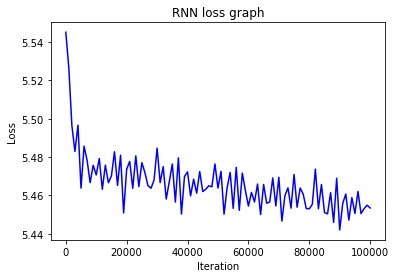

In [20]:
%matplotlib inline
#Graphical results
import matplotlib.pyplot as plt
plt.plot(x, y, color='blue',)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("RNN loss graph")
print("minimum loss is",min(y))